# TP4 - Word embeddings training

Group members:
- Thanh Gia Hieu KHUONG
- Ragi BHATT
- Benedictus Kent RACHMAT 

Reference: [LINK](https://saharghannay.github.io/courses/cours1/example1/)

## Requirements

In [ ]:
!pip install -q gensim fasttext

In [ ]:
# Importing libraries

import re
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.utils import simple_preprocess
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')

In [ ]:
# Download data

!wget https://perso.limsi.fr/neveol/TP_ISD2020.zip
!unzip TP_ISD2020.zip

--2024-02-08 17:29:35--  https://perso.limsi.fr/neveol/TP_ISD2020.zip
Resolving perso.limsi.fr (perso.limsi.fr)... 129.175.134.198
Connecting to perso.limsi.fr (perso.limsi.fr)|129.175.134.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11397405 (11M) [application/zip]
Saving to: ‘TP_ISD2020.zip.3’

TP_ISD2020.zip.3    100%[===================>]  10.87M  7.22MB/s    in 1.5s    

2024-02-08 17:29:37 (7.22 MB/s) - ‘TP_ISD2020.zip.3’ saved [11397405/11397405]

Archive:  TP_ISD2020.zip
replace QUAERO_FrenchMed/EMEA/EMEAdev_layer1_ID.conll? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Preprocess

In [ ]:
def read_ospl(file_path):
  """Reading the corpora"""
  sentences = [] # List to store sentences
  with open(file_path, 'r', encoding='utf-8') as file:
      for line in file:
          tokens = line.strip().split() # Splitting the line into tokens
          sentences.append(tokens) # Appending the tokens to the list
  return sentences

In [ ]:
FRENCH_MED_PRESS_PATH = "./QUAERO_FrenchMed/QUAERO_FrenchMed_traindev.ospl"
FRENCH_PRESS_PATH = "./QUAERO_FrenchPress/QUAERO_FrenchPress_traindev.ospl"

In [ ]:
french_med = read_ospl(FRENCH_MED_PRESS_PATH)
french_press = read_ospl(FRENCH_PRESS_PATH)

In [ ]:
# Sentence in French Med
for sentence in french_med[:5]:
    print(' '.join(sentence))

In [ ]:
# Sentence in French Press
for sentence in french_press[:5]:
    print(' '.join(sentence))

In [ ]:
def preprocess(sentences):
  """ Now we will preprocess the data by removing stopwords and punctuations """
  stop_words = set(stopwords.words('french')) # Set of stopwords
  preprocessed_sentences = [] # List to store preprocessed sentences
  for sentence in sentences:
      preprocessed_sentence = [] # List to store preprocessed sentence
      for word in sentence:
          word = word.lower() # Converting the word to lowercase
          if word.isalpha() and word not in stop_words: # Checking if the word is an alphabet and not a stopword
              preprocessed_sentence.append(word) # Appending the word to the list
      preprocessed_sentences.append(preprocessed_sentence) # Appending the preprocessed sentence to the list
  return preprocessed_sentences

In [ ]:
french_med_preprocessed = preprocess(french_med)
french_press_preprocessed = preprocess(french_press)

In [ ]:
for sentence in french_med_preprocessed[:5]:
    print(' '.join(sentence))

In [ ]:
for sentence in french_press_preprocessed[:5]:
    print(' '.join(sentence))

In [ ]:
def preprocess_gensim(file_path):
  preprocessed_text=[]
  with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
      # Tokenize and lowercase the text
      tokens = simple_preprocess(line, deacc=True)
      preprocessed_text.append(tokens)
  return preprocessed_text

In [ ]:
french_med_preprocessed_gensim = preprocess_gensim(FRENCH_MED_PRESS_PATH)
french_press_preprocessed_gensim = preprocess_gensim(FRENCH_PRESS_PATH)

In [ ]:
# Sentence in French Med
for sentence in french_med_preprocessed_gensim[:5]:
    print(' '.join(sentence))

In [ ]:
# Sentence in French Press
for sentence in french_press_preprocessed_gensim[:5]:
    print(' '.join(sentence))

## Word2Vec and fasttext training

In [ ]:
from gensim.models import Word2Vec
import fasttext.util
import fasttext
import os

In [ ]:
def train_word2vec(preprocessed_sentences, model_type, output_file):
    model = Word2Vec(preprocessed_sentences, vector_size=100, window=5, min_count=1, sg=(model_type == "skipgram"))
    model.save(output_file)

# Train and save models
train_word2vec(french_med_preprocessed_gensim, 'cbow', 'word2vec_cbow_med.model')
train_word2vec(french_med_preprocessed_gensim, 'skipgram', 'word2vec_skipgram_med.model')
train_word2vec(french_press_preprocessed_gensim, 'cbow', 'word2vec_cbow_press.model')
train_word2vec(french_press_preprocessed_gensim, 'skipgram', 'word2vec_skipgram_press.model')

In [ ]:
def train_fasttext(preprocessed_sentences, output_file):
    with open("temp.txt", "w", encoding="utf-8") as f:
        for sentence in preprocessed_sentences:
            f.write(" ".join(sentence) + "\n")
    model = fasttext.train_unsupervised('temp.txt', model='cbow', dim=100, minCount=1)
    model.save_model(output_file)
    os.remove("temp.txt")

# Train and save models
train_fasttext(french_med_preprocessed, 'fasttext_cbow_med.bin')
train_fasttext(french_press_preprocessed, 'fasttext_cbow_press.bin')

In [ ]:
def load_model(model_path, is_fasttext=False):
  if is_fasttext:
    return fasttext.load_model(model_path)
  else:
    model = Word2Vec.load(model_path)
    return model.wv

# Load models
models = {
    'word2vec_cbow_med': load_model('word2vec_cbow_med.model'),
    'word2vec_skipgram_med': load_model('word2vec_skipgram_med.model'),
    'word2vec_cbow_press': load_model('word2vec_cbow_press.model'),
    'word2vec_skipgram_press': load_model('word2vec_skipgram_press.model'),
    'fasttext_cbow_med': load_model('fasttext_cbow_med.bin', is_fasttext=True),
    'fasttext_cbow_press': load_model('fasttext_cbow_press.bin', is_fasttext=True)
}

candidate_words = ['patient', 'traitement', 'maladie', 'solution', 'jaune']

In [ ]:
def find_closest_words(models, word):
  results = {}
  for model_name, model in models.items():
      try:
          if 'fasttext' in model_name:
              similar_words = model.get_nearest_neighbors(word, 10)
              # Convert FastText results to a similar format as Word2Vec results
              similar_words = [(neighbor_word, score) for score, neighbor_word in similar_words]
          else:
              similar_words = model.most_similar(word, topn=10)
          results[model_name] = similar_words
      except KeyError:
          results[model_name] = f"'{word}' not in vocabulary."
  return results

# Evaluate
for word in candidate_words:
  print(f"Closest words to '{word}':")
  similarities = find_closest_words(models, word)
  for model_name, similar_words in similarities.items():
      print(f"\nModel: {model_name}")
      print(similar_words)
  print("\n" + "="*50 + "\n")

## Visualization

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
# Let's Visualize the Word Embeddings
model_cbow_med = Word2Vec.load("word2vec_cbow_med.model")
words_cbow_med = list(model_cbow_med.wv.index_to_key)[:20]
word_vector_cbow_med = np.array([model_cbow_med.wv[word] for word in words_cbow_med])

In [ ]:
# PCA
pca = PCA(n_components=2)
reduced_vectors_pca = pca.fit_transform(word_vector_cbow_med)

In [ ]:
# T-SNE
tsne = TSNE(n_components=2, perplexity=5, n_iter=300)
reduced_vectors_tsne = tsne.fit_transform(word_vector_cbow_med)

In [ ]:
def plot_embeddings(reduced_vectors, words_cbow_med, title="Word Embeddings"):
  plt.figure(figsize=(10,10))
  for word, (x,y) in zip(words_cbow_med, reduced_vectors):
    plt.scatter(x,y)
    plt.annotate(word, xy=(x, y), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
  plt.show()

In [ ]:
# Plotting the PCA reduced vectors
plot_embeddings(reduced_vectors_pca, words_cbow_med , title='PCA reduced Word Embeddings')

In [ ]:
plot_embeddings(reduced_vectors_tsne, words_cbow_med, title="t-SNE reduced Word Embeddings")

In [ ]:
from wordcloud import WordCloud

def visualize_similarwords(model, candidate_word, topn=20, use_tsne=True):
    # Ensure we're using KeyedVectors for vocabulary operations
    keyed_vectors = model.wv if hasattr(model, 'wv') else model

    # Check if the word is in the model's vocabulary
    if hasattr(keyed_vectors, 'key_to_index'): # KeyedVectors
        if candidate_word in keyed_vectors.key_to_index:
            # Get similar words
            similar_words = keyed_vectors.most_similar(candidate_word, topn=topn)
            print(similar_words)
            words = [word for word, _ in similar_words]
            vectors = np.array([keyed_vectors[word] for word in words])
            # Dimensionality reduction
            if use_tsne:
                tsne = TSNE(n_components=2, perplexity=5, n_iter=300)
                reduced_vectors = tsne.fit_transform(vectors)
            else:
                pca = PCA(n_components=2)
                reduced_vectors = pca.fit_transform(vectors)

            # Plotting
            plt.figure(figsize=(10, 10))
            for word, (x, y) in zip(words, reduced_vectors):
                plt.scatter(x, y)
                plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
            plt.title(f"Words similar to '{candidate_word}' ({'TSNE' if use_tsne else 'PCA'})")
            plt.show()

            # Generating Word Cloud
            word_freq = {word: freq for word, freq in similar_words}
            wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(word_freq)

            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f"Word Cloud of words similar to '{candidate_word}'")
            plt.show()

        else:
            print(f"'{word}' not found in the model's vocabulary.")
    else: # FastText
        if candidate_word in model.get_words():
            # Get similar words
            similar_words = model.get_nearest_neighbors(candidate_word, topn)
            print(similar_words)
            words = [word for _, word in similar_words]
            vectors = np.array([model.get_word_vector(word) for word in words])
            # Dimensionality reduction
            if use_tsne:
                tsne = TSNE(n_components=2, perplexity=5, n_iter=300)
                reduced_vectors = tsne.fit_transform(vectors)
            else:
                pca = PCA(n_components=2)
                reduced_vectors = pca.fit_transform(vectors)

            # Plotting
            plt.figure(figsize=(10, 10))
            for word, (x, y) in zip(words, reduced_vectors):
                plt.scatter(x, y)
                plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
            plt.title(f"Words similar to '{candidate_word}' ({'TSNE' if use_tsne else 'PCA'})")
            plt.show()

            # Generating Word Cloud
            word_freq = {word: freq for freq, word in similar_words}
            wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(word_freq)

            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f"Word Cloud of words similar to '{candidate_word}'")
            plt.show()
        else:
            print(f"'{word}' not found in the model's vocabulary.")

Visualizations for: patient

Model: word2vec_cbow_med
[('le', 0.9992106556892395), ('et', 0.9992029666900635), ('chez', 0.999174952507019), ('les', 0.9991692900657654), ('un', 0.999168336391449), ('une', 0.9991649389266968), ('des', 0.9991640448570251), ('dans', 0.9991493225097656), ('sur', 0.9991477131843567), ('ou', 0.9991430640220642), ('apres', 0.9991344213485718), ('en', 0.9991214871406555), ('du', 0.9991047978401184), ('plus', 0.9990984201431274), ('pour', 0.9990983009338379), ('de', 0.9990866780281067), ('par', 0.9990856051445007), ('avec', 0.9990804195404053), ('peut', 0.9990689158439636), ('etude', 0.9990663528442383)]


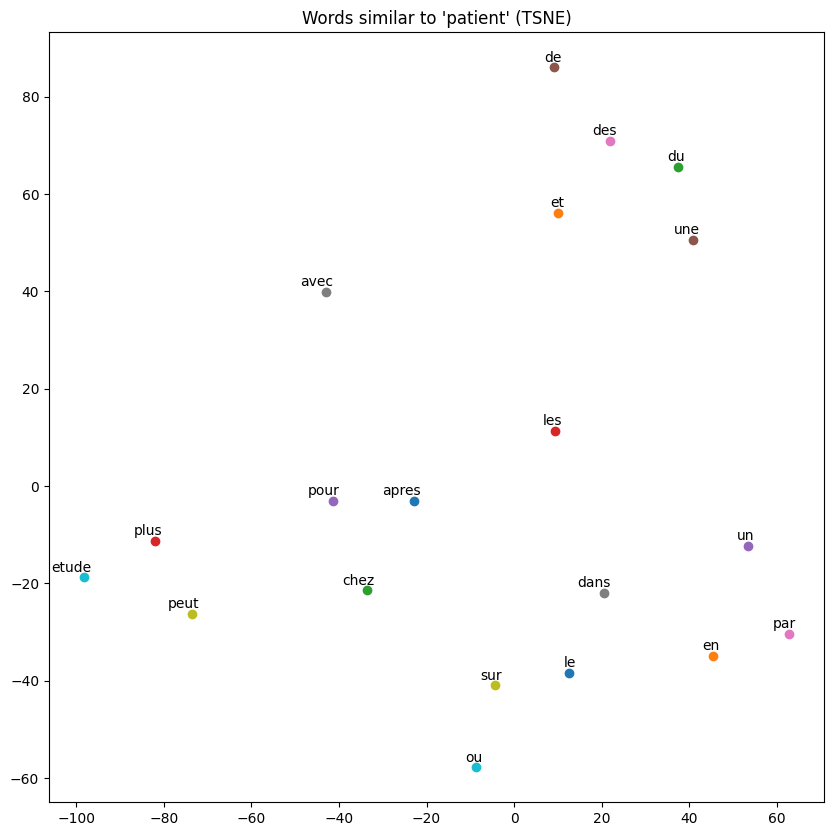

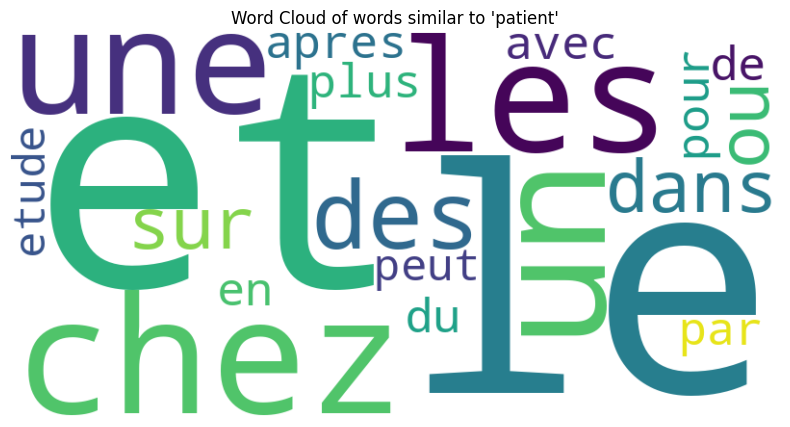

--------------------------------------------------
Model: word2vec_skipgram_med
[('symptomes', 0.9980421662330627), ('qui', 0.9978851079940796), ('risque', 0.9978722333908081), ('nouveau', 0.9978300929069519), ('recommande', 0.9978272914886475), ('infection', 0.9976195096969604), ('produit', 0.9975483417510986), ('grossesse', 0.9974854588508606), ('avant', 0.9973490238189697), ('cette', 0.9972856044769287), ('medecins', 0.9972825050354004), ('peuvent', 0.9972277283668518), ('interrompu', 0.9971446394920349), ('donc', 0.9970656037330627), ('egalement', 0.9970436692237854), ('non', 0.9969601631164551), ('ayant', 0.9969365000724792), ('fonction', 0.9969296455383301), ('cependant', 0.9968854784965515), ('lemp', 0.9967581033706665)]


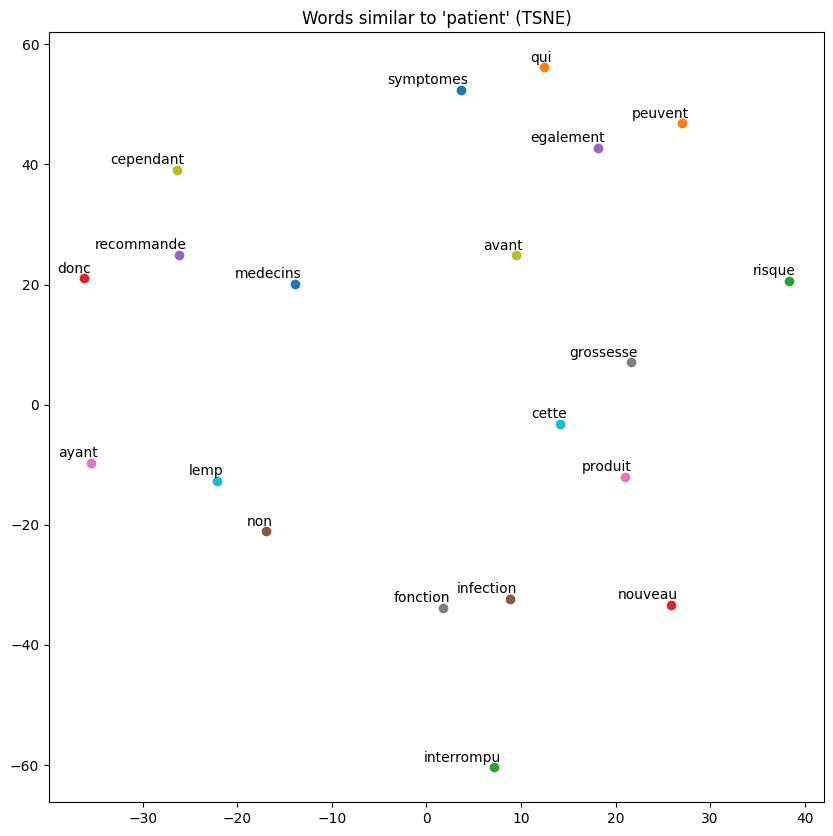

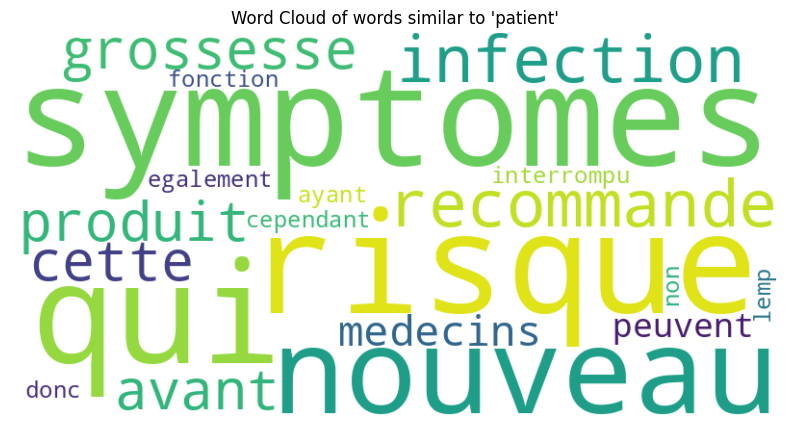

--------------------------------------------------
Model: word2vec_cbow_press
[('depasse', 0.9146333932876587), ('adaptation', 0.9110904335975647), ('roule', 0.9108878970146179), ('emballage', 0.9100799560546875), ('probablement', 0.9094030261039734), ('charlie', 0.9084534049034119), ('anonyme', 0.9076554179191589), ('ordinateur', 0.9069255590438843), ('humiliation', 0.9056317210197449), ('fatigue', 0.9051691889762878), ('innovation', 0.9047582149505615), ('riche', 0.9033954739570618), ('professionnel', 0.9033588171005249), ('gabriele', 0.9029845595359802), ('magnifique', 0.9029641151428223), ('equilibre', 0.9020699858665466), ('glisse', 0.9020025730133057), ('guette', 0.9019747972488403), ('dvd', 0.9015891551971436), ('interne', 0.9015577435493469)]


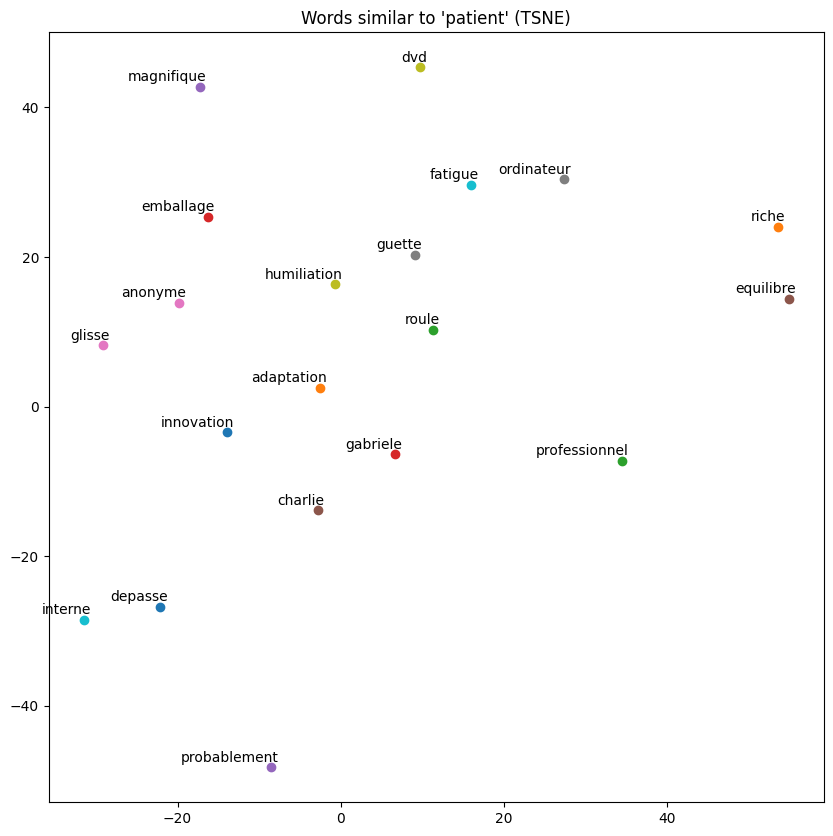

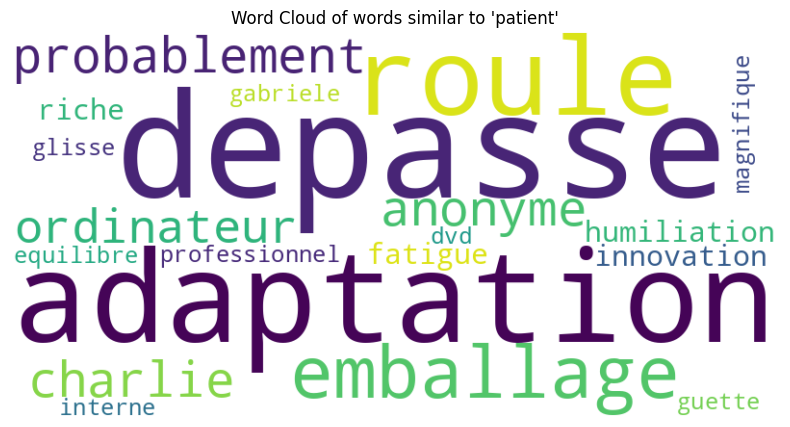

--------------------------------------------------
Model: word2vec_skipgram_press
[('aise', 0.9644244909286499), ('circonstance', 0.9539641737937927), ('trou', 0.95367032289505), ('epouvantable', 0.9532575011253357), ('handicape', 0.9520140290260315), ('genant', 0.9516617059707642), ('ideologie', 0.9515365362167358), ('clown', 0.951347291469574), ('electeur', 0.951289176940918), ('animal', 0.950533926486969), ('depense', 0.9505304098129272), ('lecteur', 0.9503014087677002), ('negatif', 0.9494561553001404), ('modifie', 0.9491974115371704), ('affligeant', 0.9489268064498901), ('bousculer', 0.9484981894493103), ('ideologique', 0.9481179118156433), ('millionnaire', 0.9479097127914429), ('combattant', 0.9478910565376282), ('vieillard', 0.9474329948425293)]


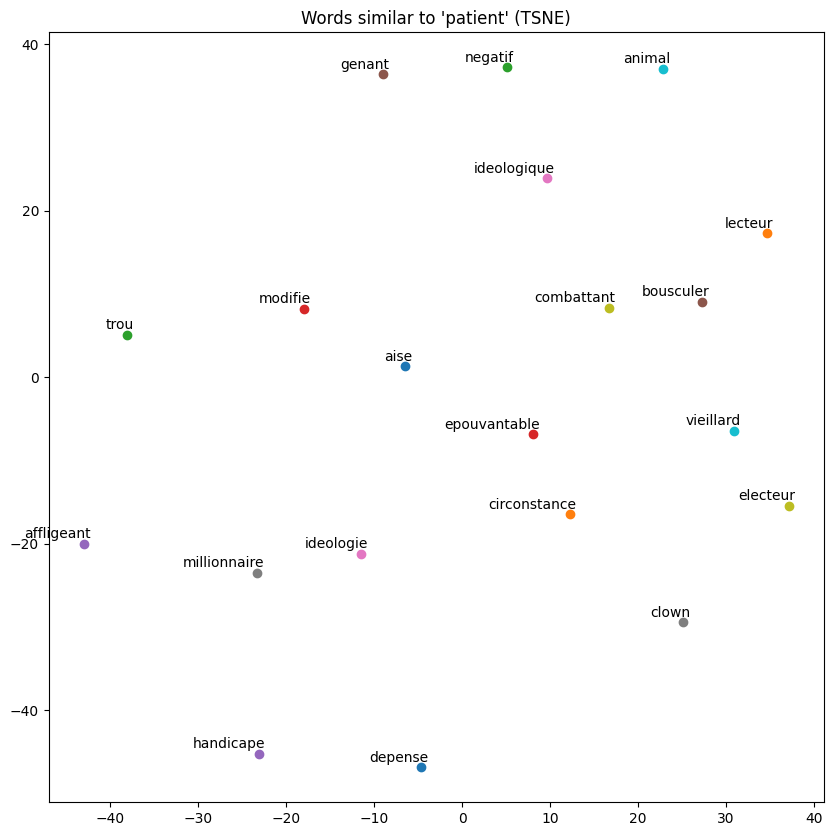

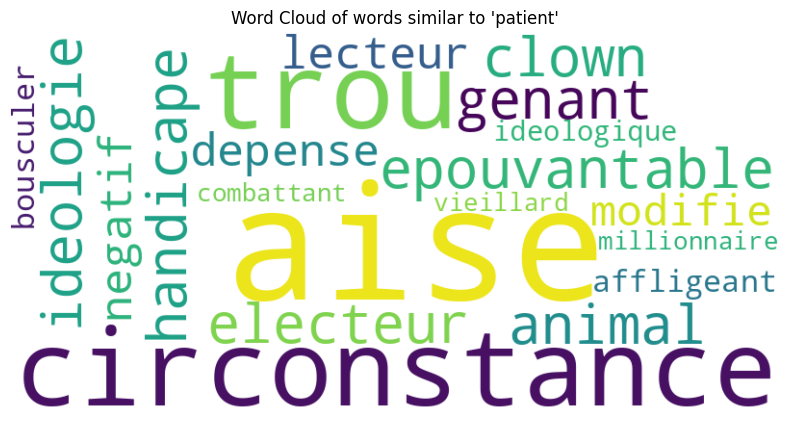

--------------------------------------------------
Model: fasttext_cbow_med
[(0.9999997615814209, 'patiente'), (0.9999996423721313, 'uniquement'), (0.9999996423721313, 'ventriculaires'), (0.9999995231628418, 'département'), (0.9999995231628418, 'isolement'), (0.9999995231628418, 'principalement'), (0.9999995231628418, 'hurlements'), (0.9999994039535522, 'alimentaire'), (0.9999994039535522, 'initialement'), (0.9999994039535522, 'tentatives'), (0.9999994039535522, 'dentaire'), (0.9999994039535522, 'segmentaires'), (0.9999994039535522, 'écoulement'), (0.9999994039535522, 'totalement'), (0.9999992847442627, 'recrutement'), (0.9999992847442627, 'cliniquement'), (0.9999992847442627, 'entourant'), (0.9999992847442627, 'conjointement'), (0.9999992847442627, 'socialement'), (0.9999992847442627, 'probablement')]


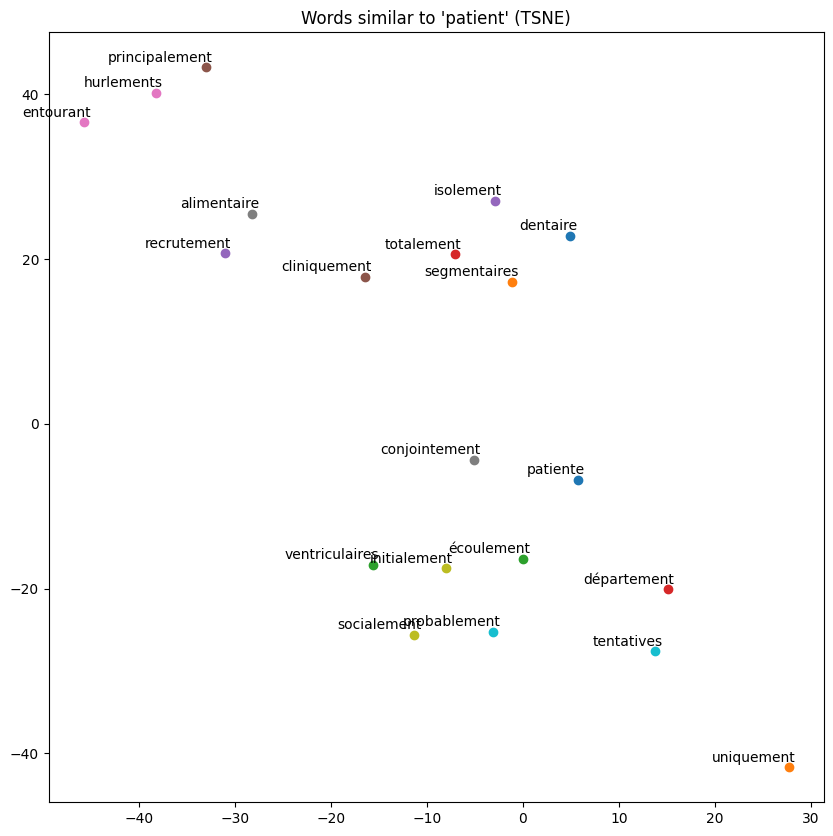

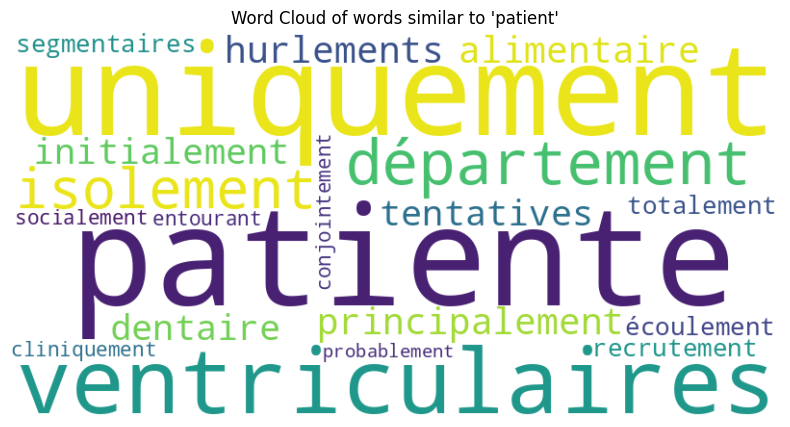

--------------------------------------------------
Model: fasttext_cbow_press
[(0.999374508857727, 'décidèrent'), (0.9993123412132263, 'délocaliseraient'), (0.9990471005439758, 'accordent'), (0.9989210963249207, 'distribuaient'), (0.9989145994186401, 'établissaient'), (0.9987871050834656, 'coefficient'), (0.9986589550971985, 'efficient'), (0.9983503222465515, 'approprient'), (0.9983202219009399, 'désignent'), (0.9982221126556396, 'impatient'), (0.9980869293212891, 'officiaient'), (0.9980611205101013, 'démilitarisent'), (0.997995138168335, 'appropriaient'), (0.9979392290115356, 'déclinent'), (0.9978640675544739, 'reprennent'), (0.9977512359619141, 'bénéficiaient'), (0.9975951910018921, 'inquiétaient'), (0.9975769519805908, 'publient'), (0.9975621700286865, 'bénéficient'), (0.9975319504737854, 'serpentant')]


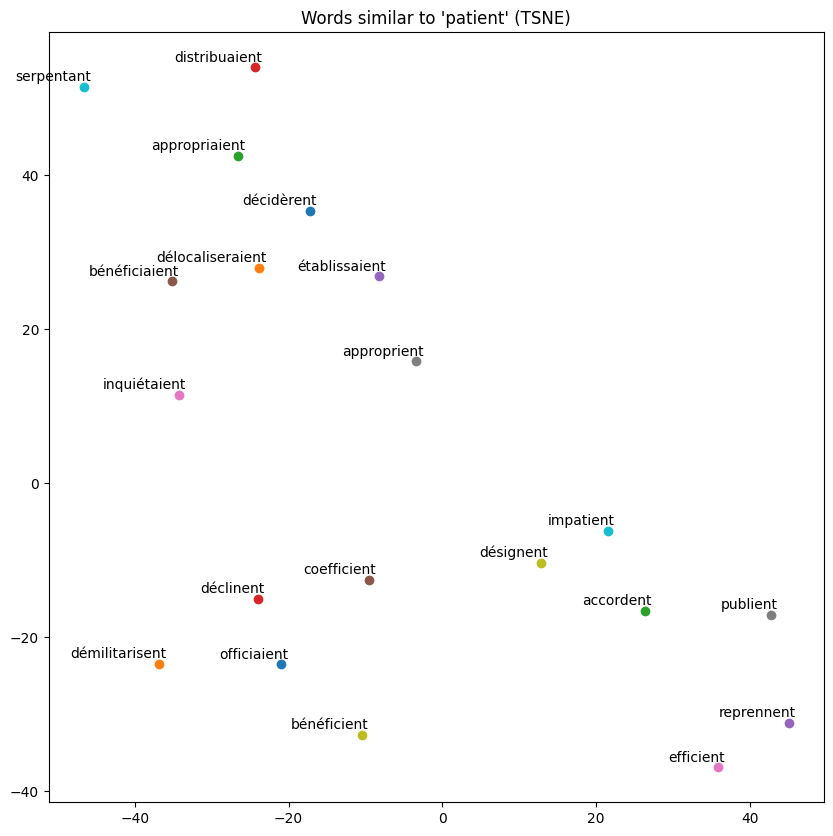

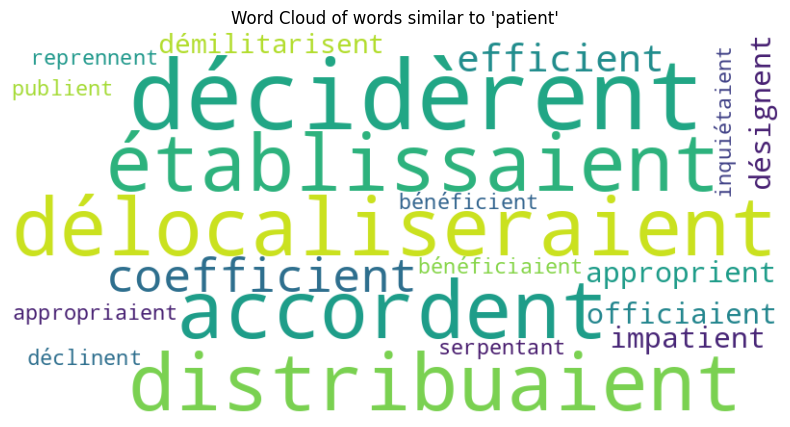

--------------------------------------------------
Visualizations for: traitement

Model: word2vec_cbow_med
[('le', 0.9996919631958008), ('du', 0.9996208548545837), ('et', 0.9996175765991211), ('la', 0.9996135234832764), ('une', 0.999610960483551), ('au', 0.9995920062065125), ('de', 0.9995911121368408), ('un', 0.9995844960212708), ('par', 0.999571681022644), ('apres', 0.999567449092865), ('les', 0.9995635747909546), ('en', 0.9995604753494263), ('des', 0.9995563626289368), ('dans', 0.999553382396698), ('etude', 0.9995516538619995), ('sur', 0.9995514154434204), ('ou', 0.9995356798171997), ('risque', 0.9995201230049133), ('chez', 0.9994968771934509), ('que', 0.9994946718215942)]


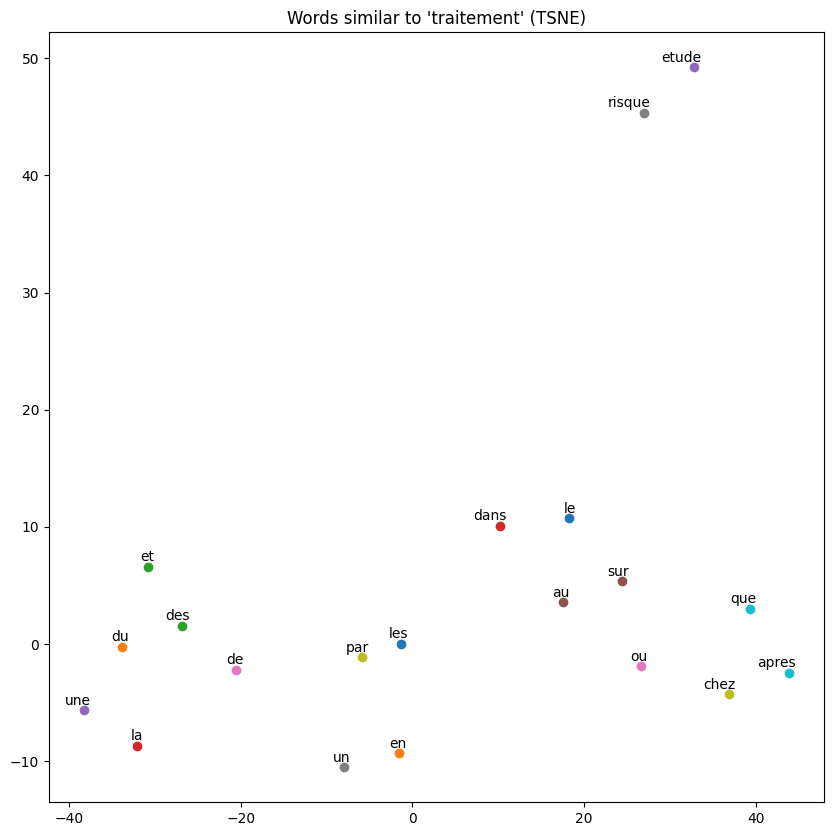

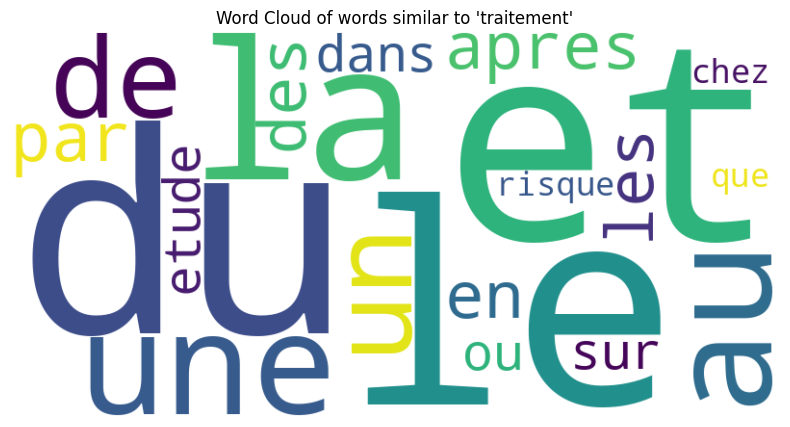

--------------------------------------------------
Model: word2vec_skipgram_med
[('le', 0.982841432094574), ('par', 0.978120744228363), ('maladie', 0.9737867712974548), ('en', 0.969964861869812), ('patients', 0.9692729711532593), ('cas', 0.9680256247520447), ('pendant', 0.967561662197113), ('tysabri', 0.9671490788459778), ('plus', 0.96682208776474), ('dans', 0.9632537364959717), ('association', 0.9631190299987793), ('medicaments', 0.9626549482345581), ('traites', 0.960633397102356), ('levodopa', 0.9605101346969604), ('semaines', 0.9604263305664062), ('devra', 0.9592159986495972), ('enfant', 0.9583979845046997), ('sep', 0.9582898616790771), ('cancer', 0.9581260085105896), ('risque', 0.9580680727958679)]


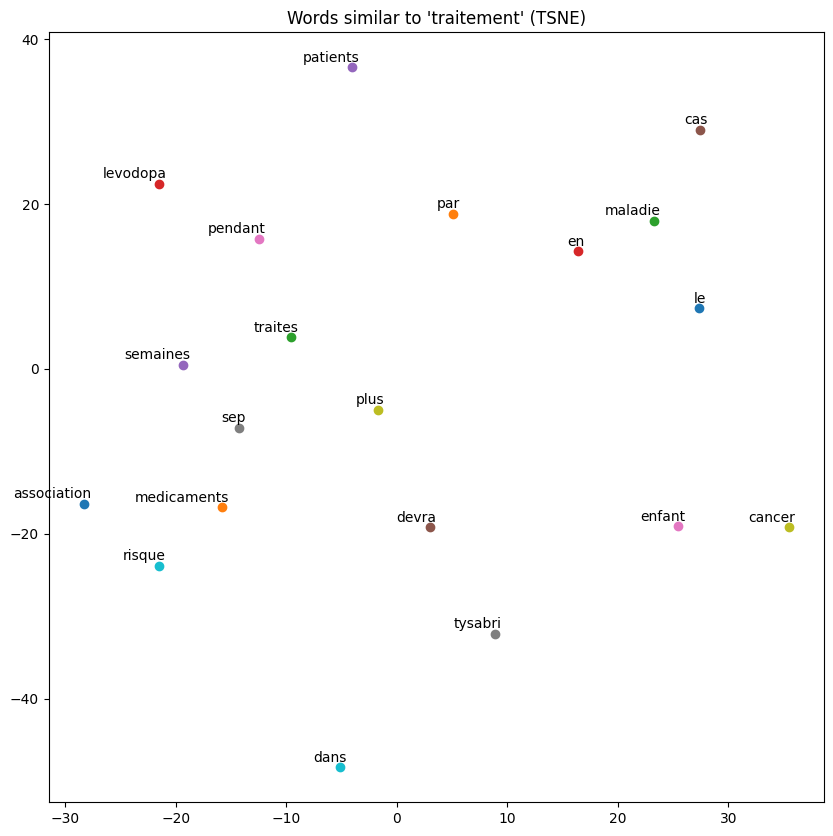

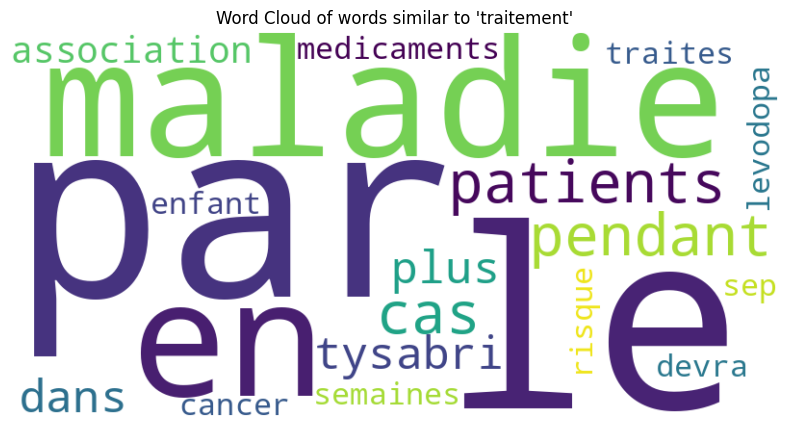

--------------------------------------------------
Model: word2vec_cbow_press
[('degre', 0.9433955550193787), ('sol', 0.9322319030761719), ('mur', 0.9307664632797241), ('chomage', 0.9300647377967834), ('mariage', 0.9291863441467285), ('bord', 0.9281328320503235), ('declin', 0.9207602739334106), ('cancer', 0.9204771518707275), ('tresor', 0.9197714328765869), ('parc', 0.9181912541389465), ('logement', 0.9175599813461304), ('repas', 0.9168552160263062), ('deficit', 0.9141563177108765), ('desespoir', 0.9120295643806458), ('calendrier', 0.9109897017478943), ('dynamo', 0.9103227853775024), ('profit', 0.9102678298950195), ('seuil', 0.9089518189430237), ('recours', 0.9077571034431458), ('passage', 0.9073944687843323)]


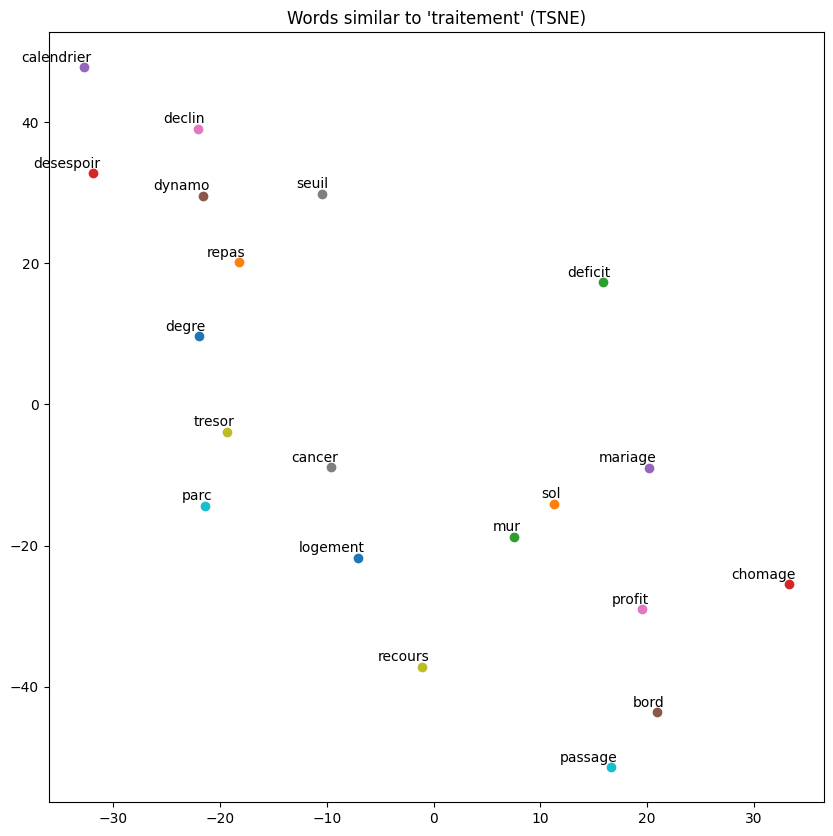

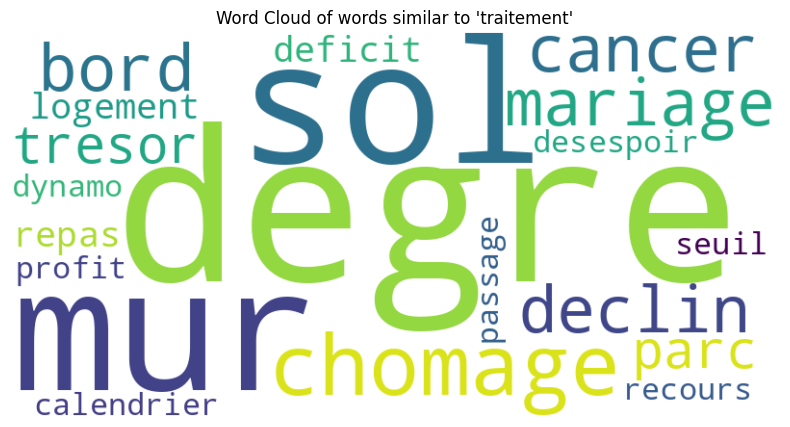

--------------------------------------------------
Model: word2vec_skipgram_press
[('tresor', 0.9036731123924255), ('outil', 0.8980703353881836), ('destine', 0.897053599357605), ('potentiel', 0.8901565670967102), ('mepris', 0.8868861794471741), ('legalite', 0.8795016407966614), ('cout', 0.8779402375221252), ('incitation', 0.8752369284629822), ('fiscale', 0.8743005394935608), ('exploitation', 0.8737388253211975), ('regulation', 0.873267650604248), ('legale', 0.8720753788948059), ('instaurer', 0.8681929707527161), ('permette', 0.8674784302711487), ('entreprendre', 0.8667449355125427), ('autonome', 0.8663585186004639), ('capital', 0.8661521673202515), ('veto', 0.8659611344337463), ('atteinte', 0.8659307956695557), ('tromper', 0.8656682968139648)]


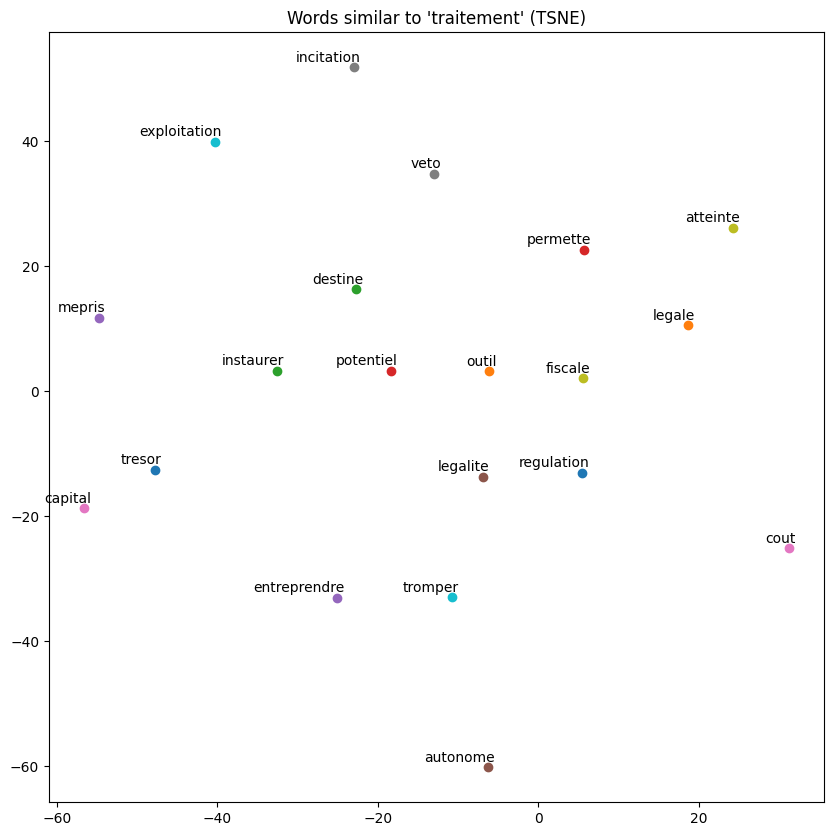

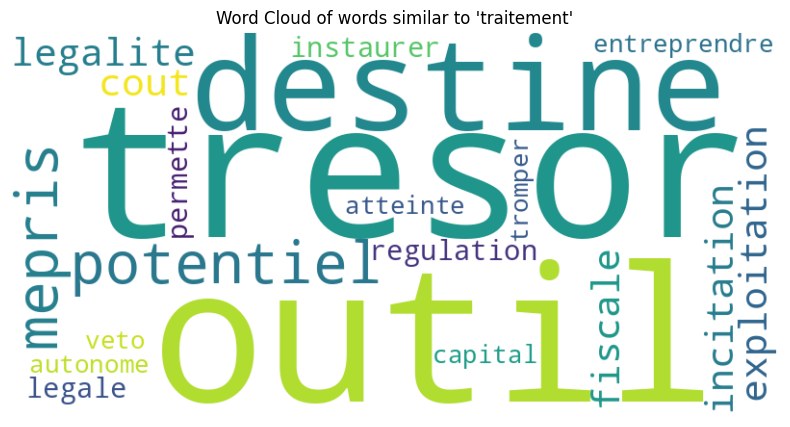

--------------------------------------------------
Model: fasttext_cbow_med
[(1.0000001192092896, 'dysfonctionnement'), (1.0, 'confrontation'), (1.0, 'réglementations'), (1.0, 'conventionnelles'), (1.0, 'chimiquement'), (0.9999998807907104, 'fractionnement'), (0.9999998807907104, 'fonctions'), (0.9999998807907104, 'complémentaire'), (0.9999998807907104, 'alimentaires'), (0.9999998807907104, 'proportionnellement'), (0.9999998807907104, 'cassation'), (0.9999998807907104, 'application'), (0.9999998807907104, 'homologues'), (0.9999998807907104, 'comportements'), (0.9999998807907104, 'conscients'), (0.9999998807907104, 'conditionnements'), (0.9999998807907104, 'mutation'), (0.9999998807907104, 'présentaient'), (0.9999998807907104, 'relativement'), (0.9999998807907104, 'lentement')]


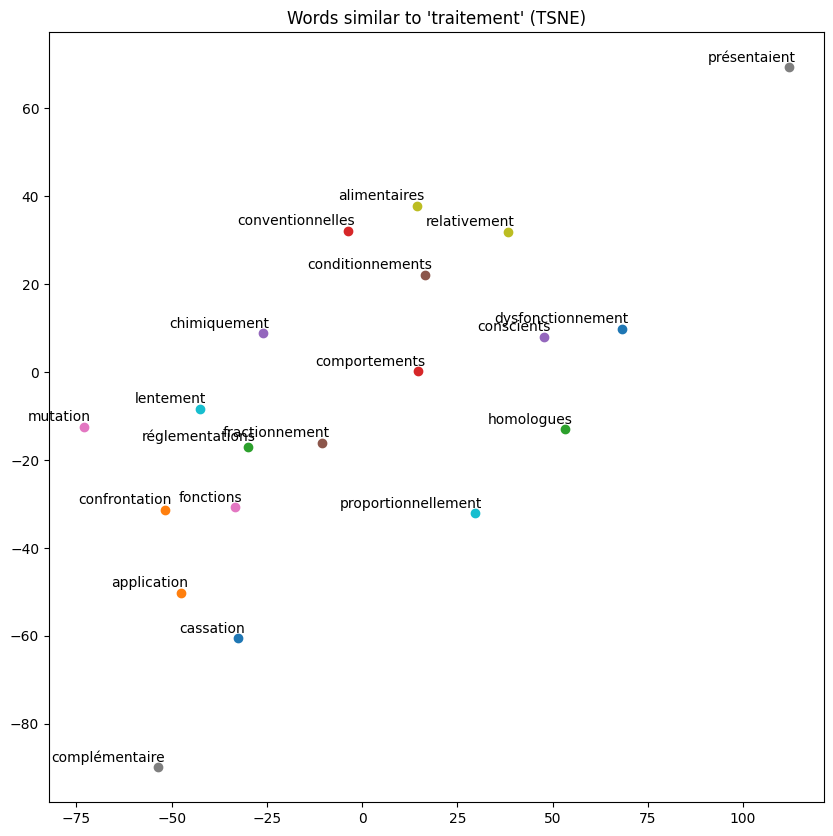

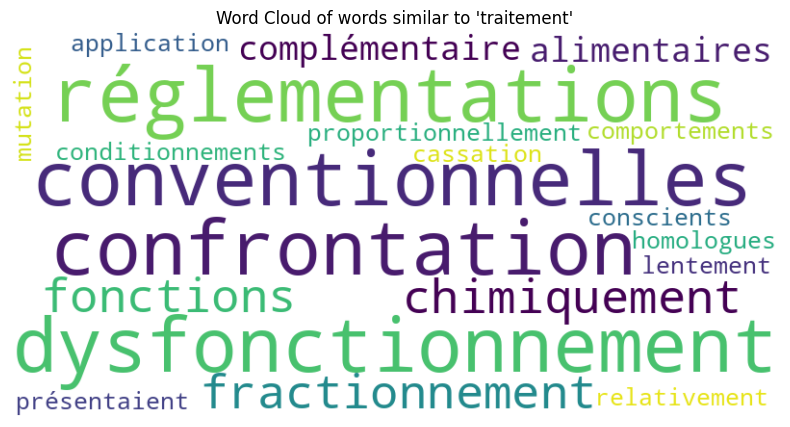

--------------------------------------------------
Model: fasttext_cbow_press
[(0.9950868487358093, 'réarmement'), (0.9939168691635132, 'déarmement'), (0.9928537011146545, 'armement'), (0.9925283193588257, 'utilement'), (0.992058277130127, 'paiement'), (0.9911564588546753, 'logement'), (0.9910460114479065, 'gaiement'), (0.9910359978675842, 'épuisement'), (0.9899978637695312, 'contentement'), (0.989866316318512, 'dépècement'), (0.9897330403327942, 'placement'), (0.9896977543830872, 'événement'), (0.9895898103713989, 'enfermement'), (0.9894860982894897, 'sèchement'), (0.988946795463562, 'dénuement'), (0.9887105226516724, 'énervement'), (0.988641083240509, 'craquement'), (0.9885674118995667, 'enlisement'), (0.9885393381118774, 'fermement'), (0.9885011911392212, 'glissement')]


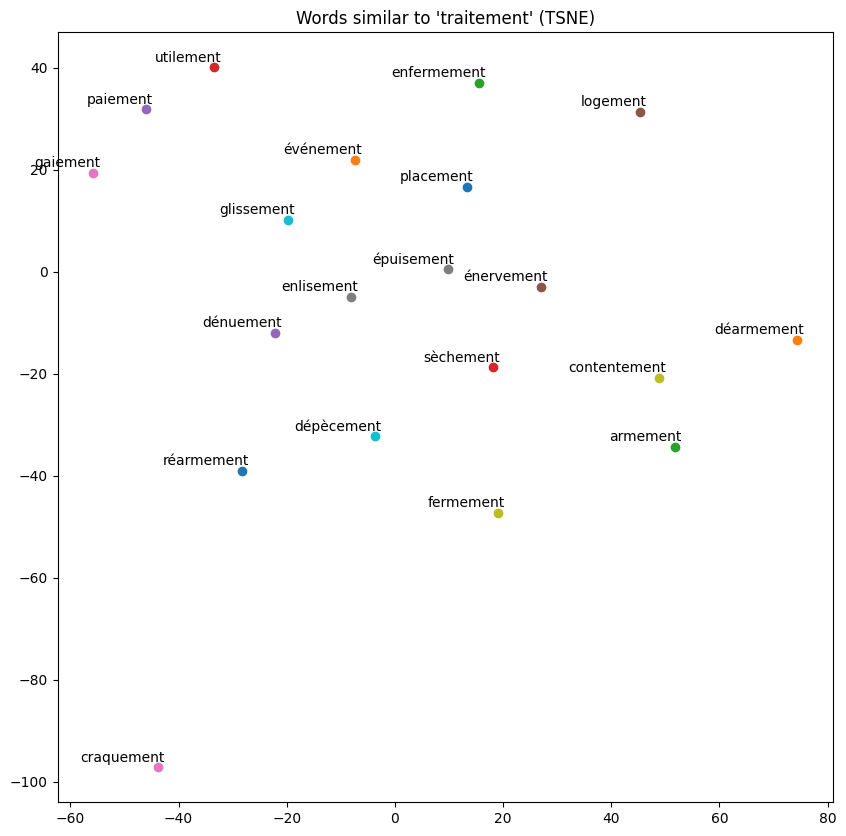

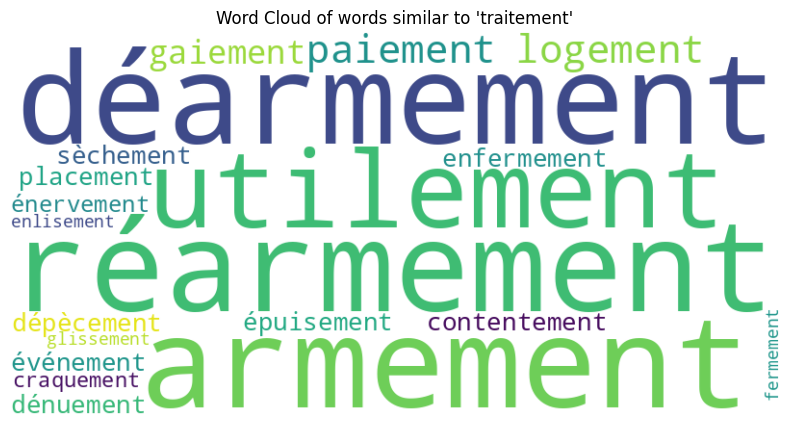

--------------------------------------------------
Visualizations for: maladie

Model: word2vec_cbow_med
[('les', 0.9996097683906555), ('en', 0.9996078610420227), ('des', 0.9995938539505005), ('du', 0.9995892643928528), ('au', 0.9995840191841125), ('un', 0.9995648264884949), ('de', 0.999561071395874), ('une', 0.9995557069778442), ('et', 0.9995510578155518), ('par', 0.9995492100715637), ('sur', 0.9995435476303101), ('dans', 0.9995319247245789), ('la', 0.9995182156562805), ('etude', 0.9995170831680298), ('le', 0.999515175819397), ('ou', 0.9995087385177612), ('chez', 0.9994947910308838), ('propos', 0.9994679689407349), ('apres', 0.9994518160820007), ('sont', 0.999421238899231)]


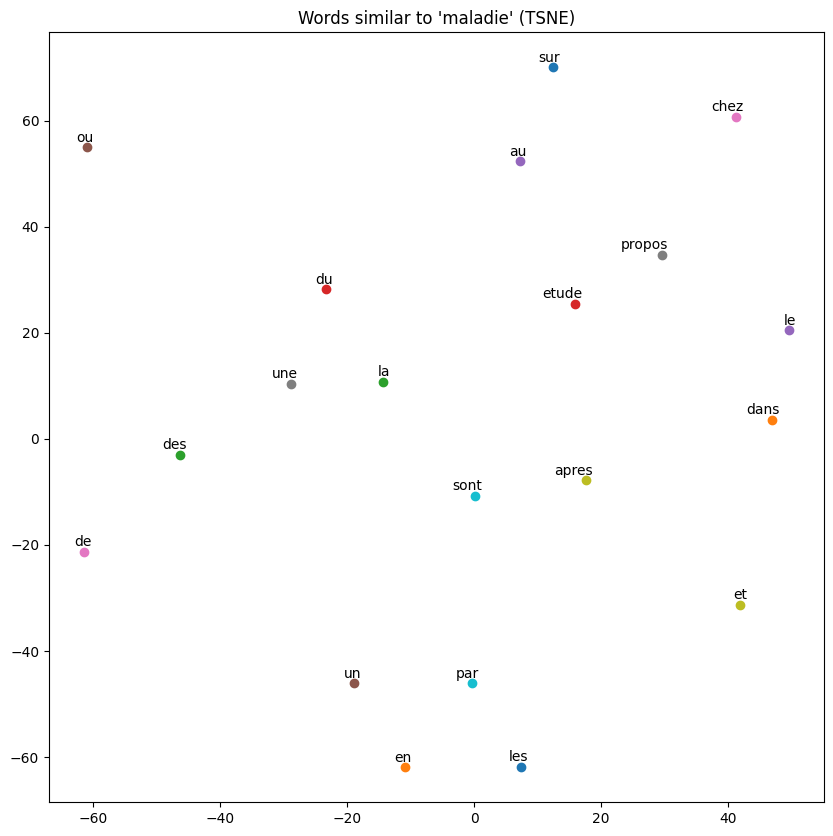

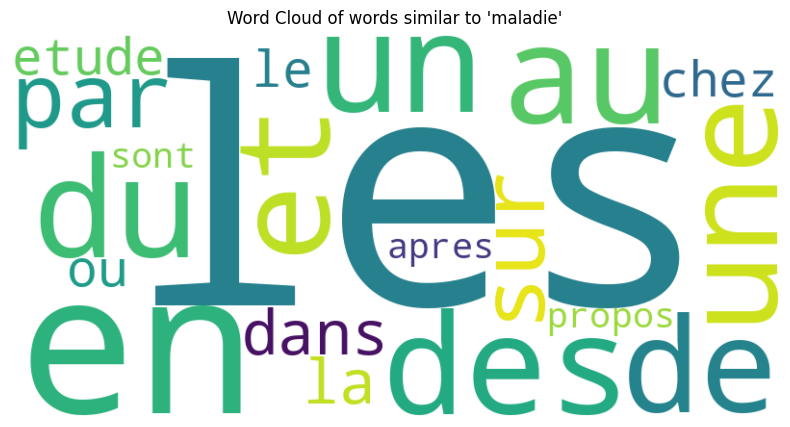

--------------------------------------------------
Model: word2vec_skipgram_med
[('en', 0.9956910014152527), ('un', 0.9948758482933044), ('cas', 0.9934551119804382), ('le', 0.9923211336135864), ('apres', 0.9917000532150269), ('levodopa', 0.9914116859436035), ('avec', 0.9911630153656006), ('association', 0.9908878803253174), ('dans', 0.9908031225204468), ('ans', 0.9906120896339417), ('augmentation', 0.9903807044029236), ('cancer', 0.9901360273361206), ('troubles', 0.9899943470954895), ('taux', 0.989924967288971), ('du', 0.9898695349693298), ('sep', 0.9897423386573792), ('cliniques', 0.9895310997962952), ('tumeurs', 0.9895288944244385), ('prise', 0.989480197429657), ('charge', 0.98945552110672)]


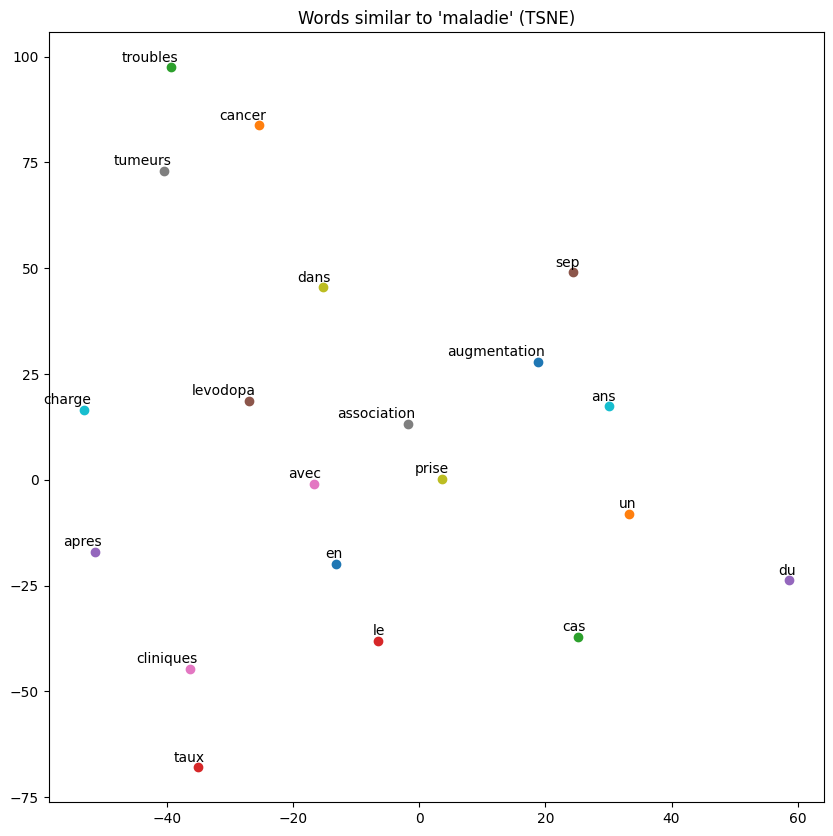

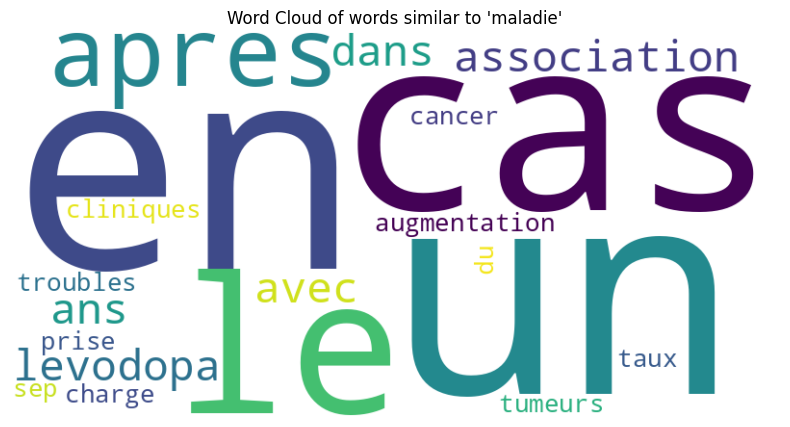

--------------------------------------------------
Model: word2vec_cbow_press
[('procedure', 0.9303226470947266), ('resistance', 0.9272659420967102), ('regle', 0.9225897789001465), ('misere', 0.9174807071685791), ('main', 0.9150418043136597), ('resolution', 0.9115350842475891), ('puissance', 0.9061219096183777), ('population', 0.9052321910858154), ('faim', 0.9047724008560181), ('panique', 0.9014751315116882), ('precarite', 0.9012890458106995), ('folie', 0.9003303050994873), ('menace', 0.8996020555496216), ('responsabilite', 0.8980698585510254), ('richesse', 0.8972035050392151), ('suspension', 0.8970786929130554), ('necessite', 0.8969016075134277), ('hotte', 0.8960838317871094), ('cible', 0.8955535292625427), ('colere', 0.8950887322425842)]


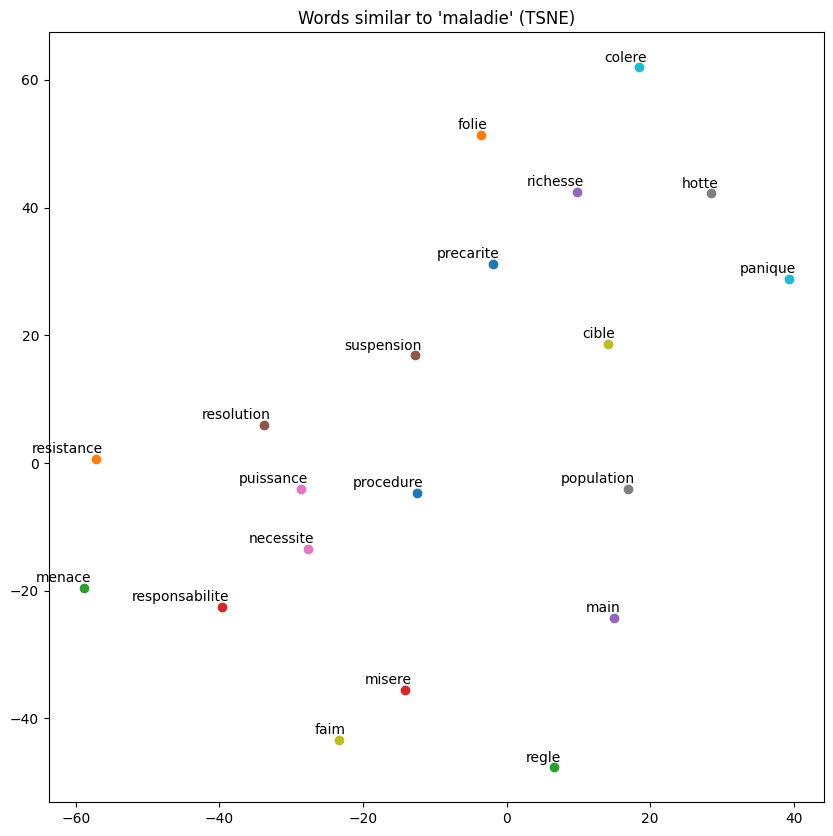

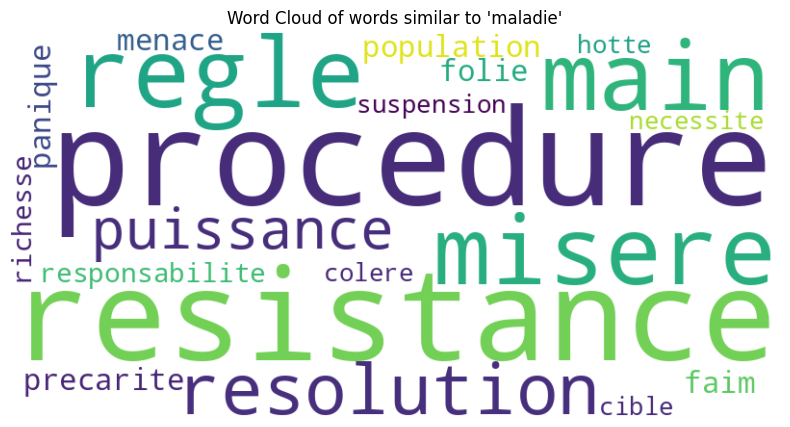

--------------------------------------------------
Model: word2vec_skipgram_press
[('decote', 0.8439692258834839), ('assurance', 0.8285292983055115), ('pauvrete', 0.8181239366531372), ('garantie', 0.8181206583976746), ('globale', 0.8123611211776733), ('precarite', 0.8099309802055359), ('caisse', 0.8088854551315308), ('epidemie', 0.8079283833503723), ('entrepris', 0.8072202205657959), ('douleur', 0.8048003911972046), ('misere', 0.8046709299087524), ('torture', 0.8023538589477539), ('nourriture', 0.798850417137146), ('pneumopathie', 0.7982889413833618), ('susceptible', 0.7966897487640381), ('propagation', 0.7966139316558838), ('cotisations', 0.7945747375488281), ('suppression', 0.7936333417892456), ('humaine', 0.7907878160476685), ('grippe', 0.790155827999115)]


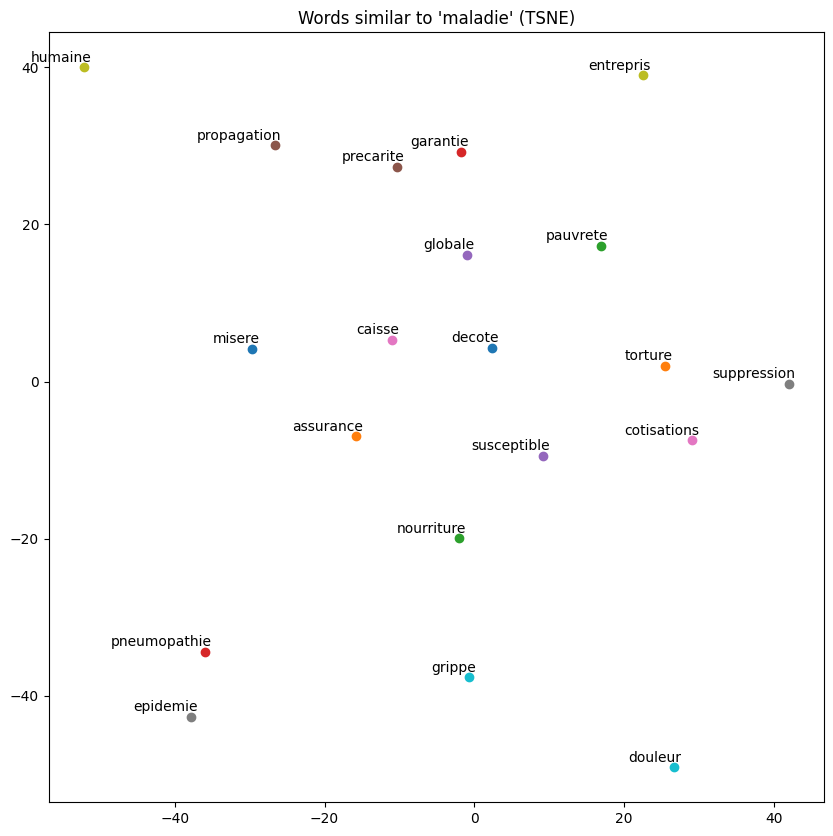

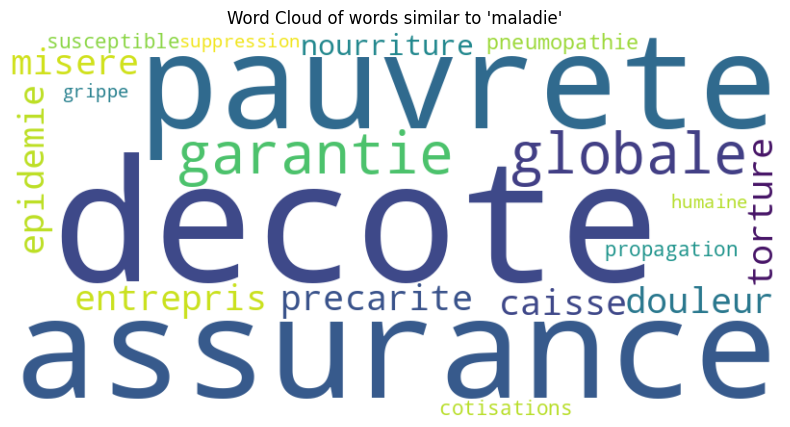

--------------------------------------------------
Model: fasttext_cbow_med
[(0.999998927116394, 'épuration'), (0.9999988675117493, 'uniquement'), (0.9999988675117493, 'hospitalisation'), (0.9999988675117493, 'vésiculaire'), (0.9999988079071045, 'technologiques'), (0.9999988079071045, 'relation'), (0.9999988079071045, 'conditionnements'), (0.9999988079071045, 'adaptation'), (0.9999988079071045, 'oculaires'), (0.9999988079071045, 'segmentaires'), (0.9999986886978149, 'conventionnelles'), (0.9999986886978149, 'hépatiques'), (0.9999986886978149, 'relaxation'), (0.9999986886978149, 'utilisation'), (0.9999986886978149, 'curarisation'), (0.9999986886978149, 'quantification'), (0.9999986886978149, 'ischémiques'), (0.9999986886978149, 'intestinale'), (0.9999986290931702, 'infantile'), (0.9999986290931702, 'industrialisation')]


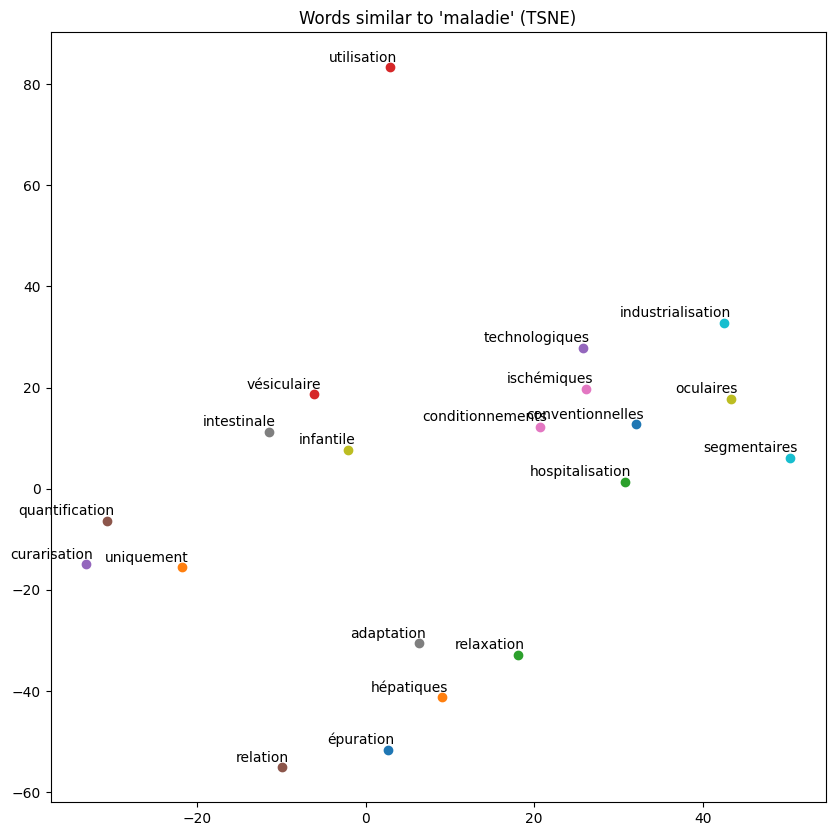

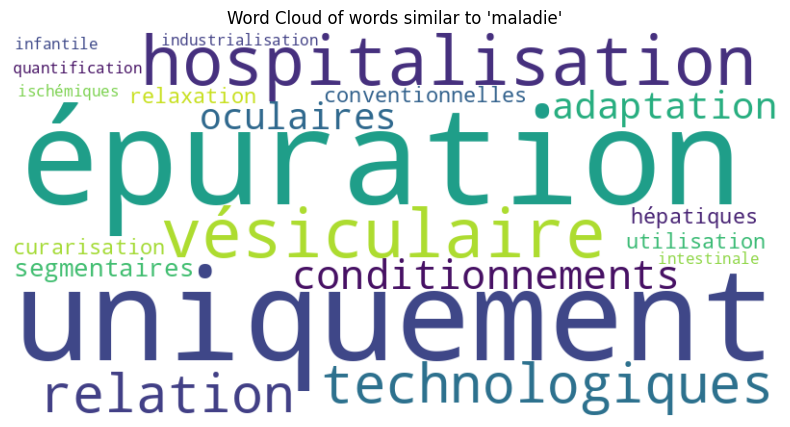

--------------------------------------------------
Model: fasttext_cbow_press
[(0.9989959001541138, 'maculé'), (0.998552143573761, 'rosinski'), (0.9983548521995544, 'vlodorp'), (0.9978706240653992, 'agora'), (0.9976915717124939, 'épinards'), (0.9975841641426086, 'froids'), (0.997464656829834, 'thermi'), (0.9973866939544678, 'manga'), (0.9973791241645813, 'caresche'), (0.9972401857376099, 'dessiné'), (0.997230589389801, 'grandcolas'), (0.9972251057624817, 'grade'), (0.9971476793289185, 'atouga'), (0.9968408346176147, 'altitude'), (0.9968141317367554, 'veloso'), (0.9967994689941406, 'erossa'), (0.996795654296875, 'mégawatt'), (0.9967833161354065, 'taxi'), (0.9967421889305115, 'pneu'), (0.996729850769043, 'médina')]


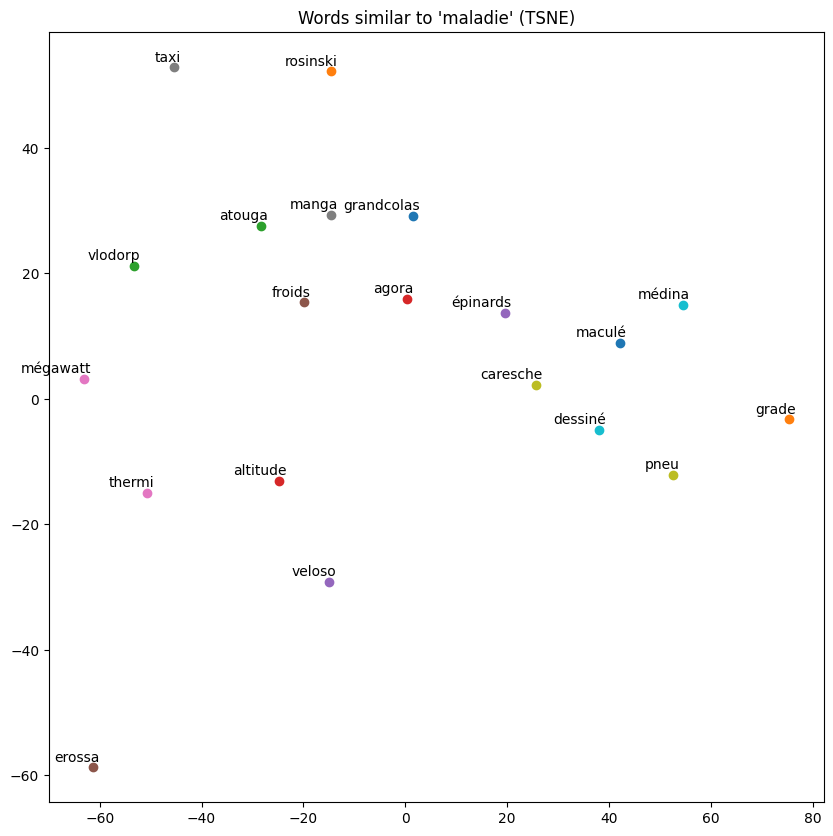

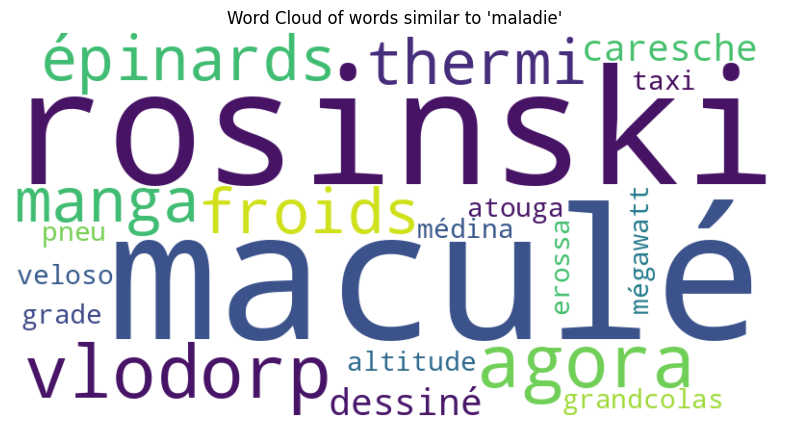

--------------------------------------------------
Visualizations for: solution

Model: word2vec_cbow_med
[('perfusion', 0.9988051652908325), ('pour', 0.9987460970878601), ('contient', 0.9987311959266663), ('ml', 0.998612642288208), ('mg', 0.99857497215271), ('dose', 0.9984859228134155), ('refludan', 0.9984636306762695), ('ou', 0.9984174966812134), ('flacon', 0.9983624815940857), ('une', 0.998332679271698), ('de', 0.9982852935791016), ('sous', 0.9982759356498718), ('par', 0.9982659816741943), ('le', 0.9982540607452393), ('peut', 0.9982497692108154), ('que', 0.9982482194900513), ('ziconotide', 0.9982357025146484), ('tasmar', 0.9982249140739441), ('apres', 0.9982203245162964), ('est', 0.9982155561447144)]


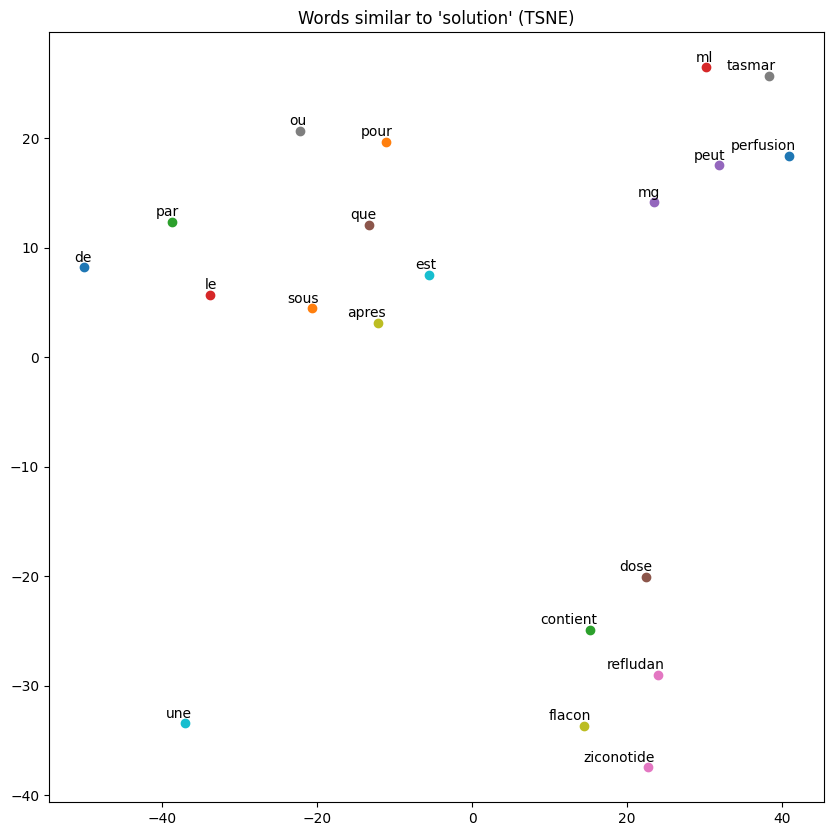

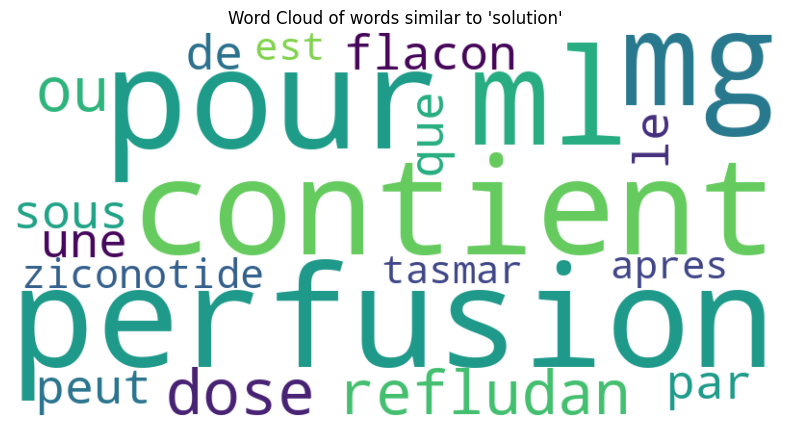

--------------------------------------------------
Model: word2vec_skipgram_med
[('ml', 0.9937612414360046), ('pour', 0.9863110184669495), ('contient', 0.9861646890640259), ('mg', 0.9854606986045837), ('perfusion', 0.9836283922195435), ('flacon', 0.9765614867210388), ('injectable', 0.966773509979248), ('chaque', 0.9557352662086487), ('comprimes', 0.9552912712097168), ('diluer', 0.9531530141830444), ('microgrammes', 0.9468318819999695), ('sodium', 0.9453699588775635), ('jour', 0.9406538605690002), ('fois', 0.9381521940231323), ('chlorure', 0.9376432299613953), ('comprime', 0.9375047087669373), ('poudre', 0.9371486306190491), ('kg', 0.9352707862854004), ('pellicule', 0.9341367483139038), ('ziconotide', 0.9316121935844421)]


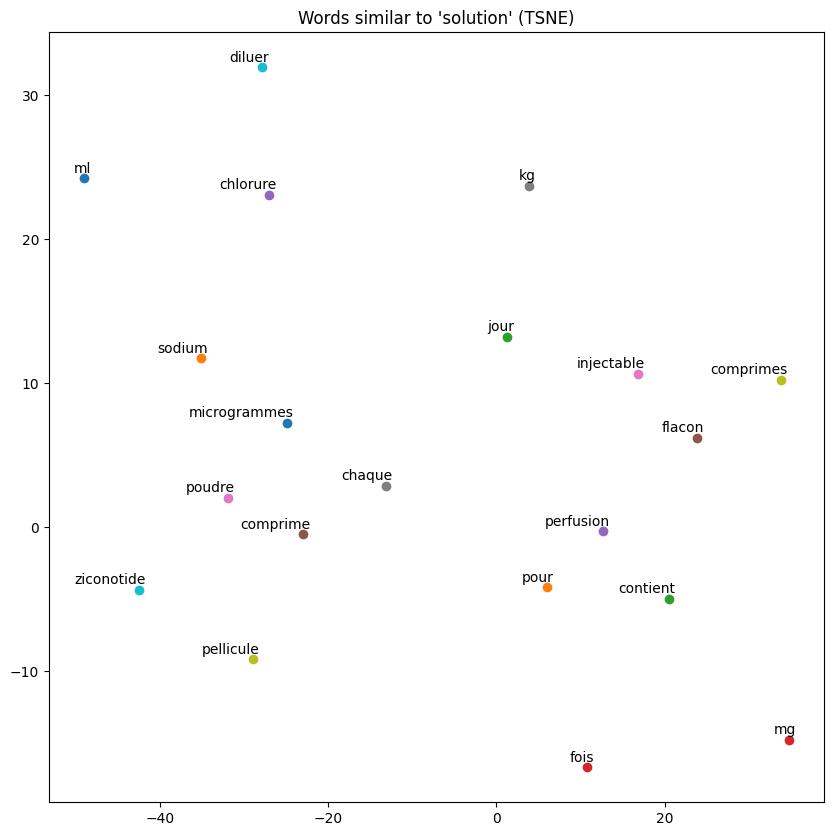

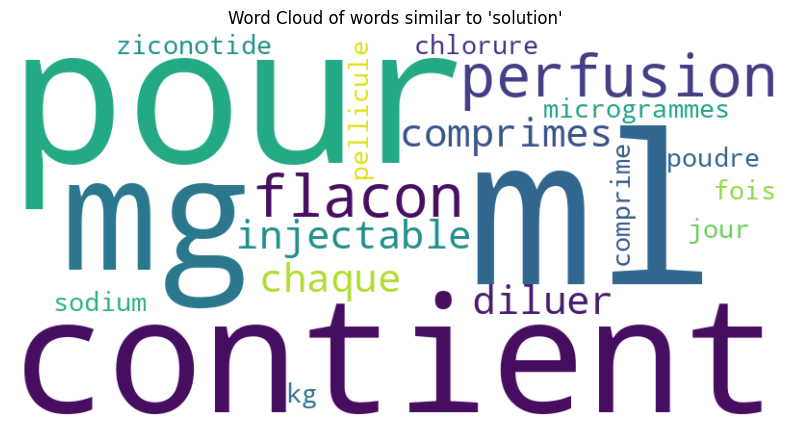

--------------------------------------------------
Model: word2vec_cbow_press
[('enrayer', 0.9330890774726868), ('douleur', 0.9209596514701843), ('mauvaise', 0.9194226861000061), ('alternative', 0.9147846698760986), ('seule', 0.9135754108428955), ('certaine', 0.910683274269104), ('sanction', 0.909267783164978), ('catastrophe', 0.9059721827507019), ('regle', 0.9042972922325134), ('meilleure', 0.9012686014175415), ('sequence', 0.900393545627594), ('quantite', 0.8999640941619873), ('longue', 0.8991615772247314), ('escroquerie', 0.8959334492683411), ('augmentation', 0.8934875726699829), ('procedure', 0.8915109038352966), ('reglementation', 0.89102703332901), ('reponse', 0.8903565406799316), ('clientele', 0.8900151252746582), ('foire', 0.8898201584815979)]


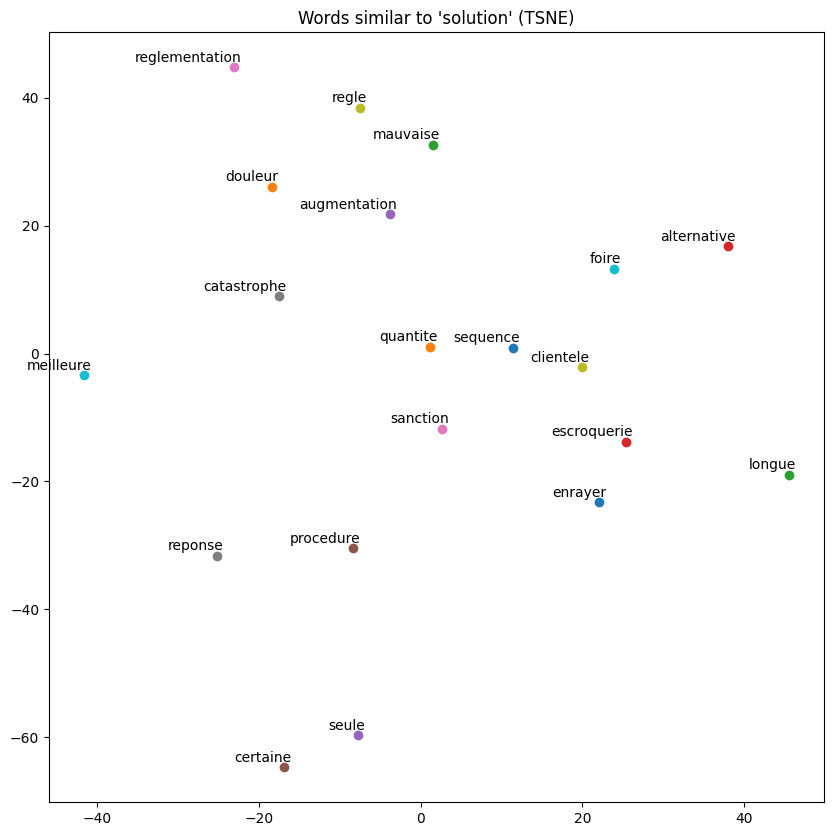

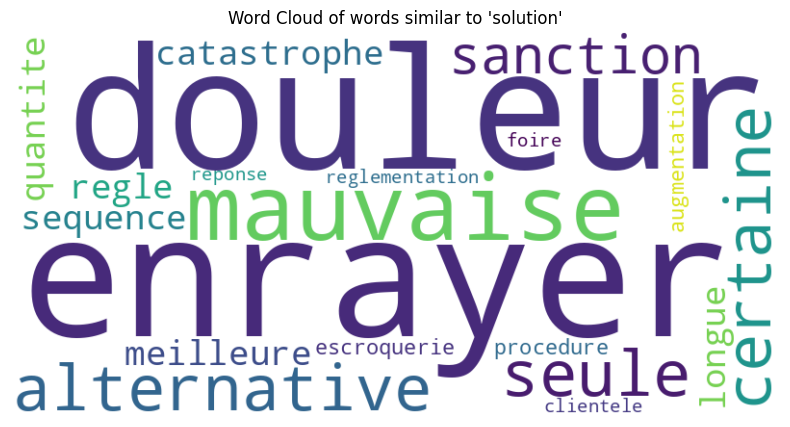

--------------------------------------------------
Model: word2vec_skipgram_press
[('alternative', 0.8884372711181641), ('reglementation', 0.8618913292884827), ('difficulte', 0.851848840713501), ('certitude', 0.8492297530174255), ('catastrophe', 0.8481817245483398), ('unie', 0.8462770581245422), ('morale', 0.8457460403442383), ('vraie', 0.844001054763794), ('strategie', 0.8439350128173828), ('consensuelle', 0.8430293202400208), ('quelconque', 0.8425686955451965), ('negative', 0.8407952785491943), ('credibilite', 0.8402193188667297), ('suffisante', 0.8400138020515442), ('manoeuvre', 0.8384009599685669), ('ambition', 0.8369201421737671), ('lecon', 0.8361262679100037), ('prealable', 0.8359953761100769), ('permettrait', 0.8351914286613464), ('conscience', 0.834928035736084)]


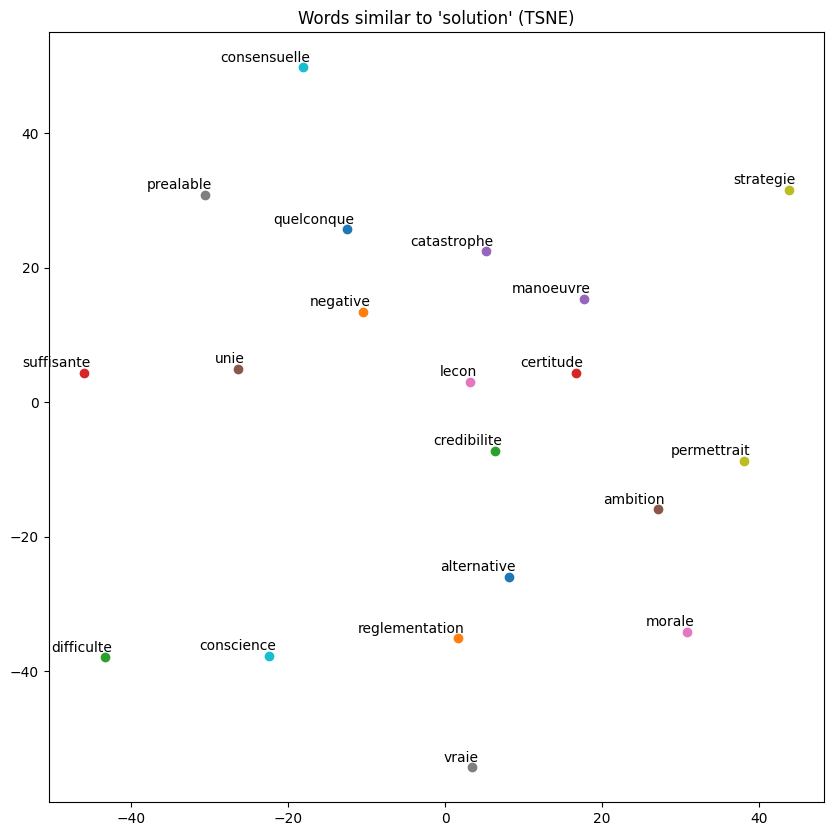

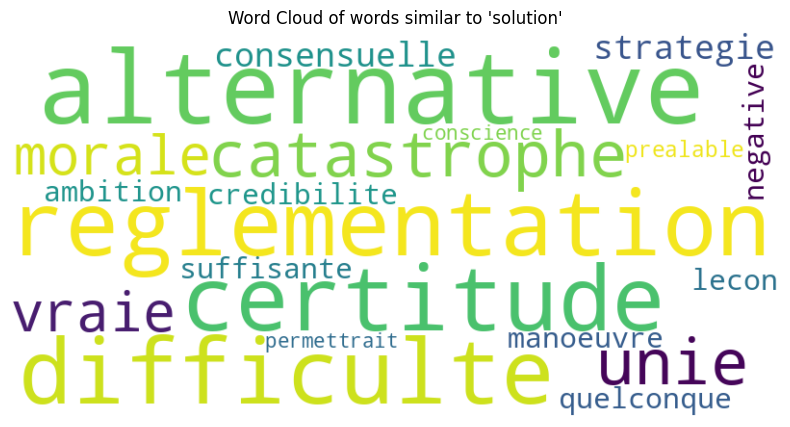

--------------------------------------------------
Model: fasttext_cbow_med
[(1.0, 'contraception'), (0.9999999403953552, 'glycorégulation'), (0.9999999403953552, 'attention'), (0.9999999403953552, 'solutions'), (0.9999998211860657, 'intéraction'), (0.9999998211860657, 'altérations'), (0.9999998211860657, 'altération'), (0.9999998211860657, 'exécution'), (0.9999998211860657, 'interception'), (0.9999998211860657, 'coloration'), (0.9999998211860657, 'dysfonctions'), (0.9999998211860657, 'respiration'), (0.9999998211860657, 'inoculation'), (0.9999998211860657, 'désignation'), (0.9999998211860657, 'notion'), (0.9999998211860657, 'réadaptation'), (0.9999998211860657, 'conditions'), (0.9999997615814209, 'miction'), (0.9999997615814209, 'évolution'), (0.9999997615814209, 'conduction')]


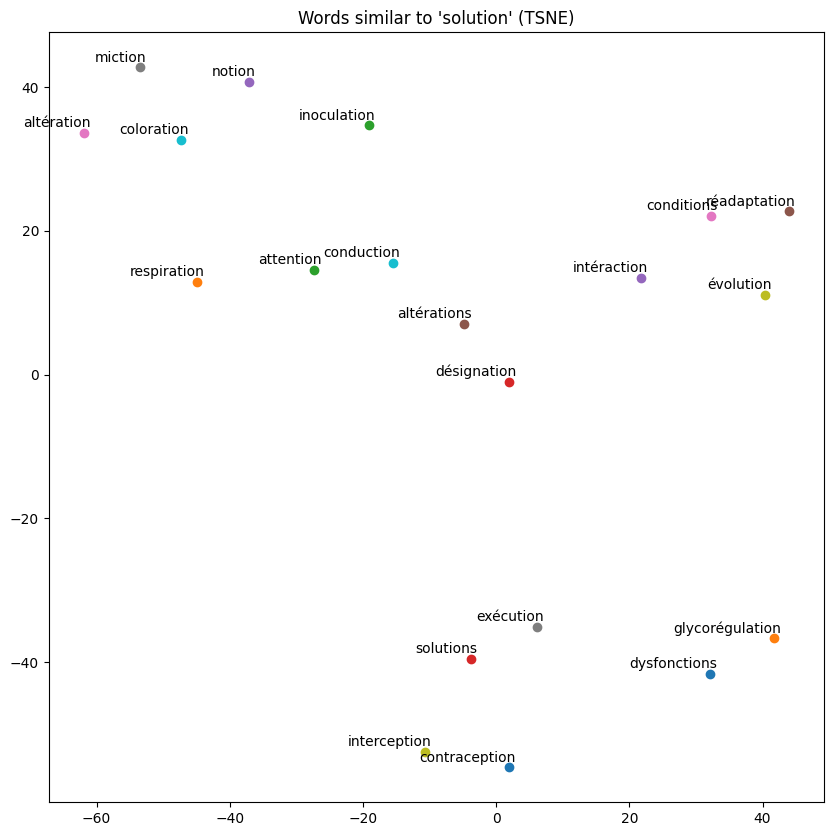

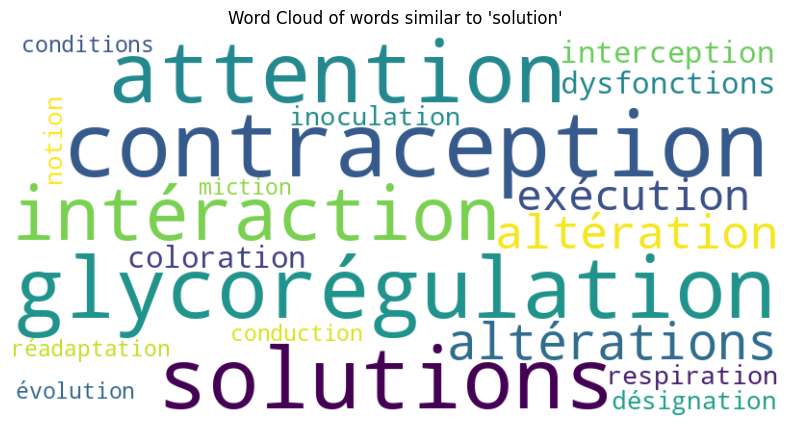

--------------------------------------------------
Model: fasttext_cbow_press
[(0.999912440776825, 'pollution'), (0.9997051954269409, 'évolution'), (0.999504029750824, 'position'), (0.999488353729248, 'protection'), (0.9992455840110779, 'révolution'), (0.9992007613182068, 'fonction'), (0.9990649819374084, 'mention'), (0.998915433883667, 'traduction'), (0.9987457990646362, 'démocratisation'), (0.9987407326698303, 'conciliation'), (0.9985684156417847, 'constellation'), (0.9985330700874329, 'réfection'), (0.9985319972038269, 'consolidation'), (0.9985114932060242, 'conservation'), (0.9984022378921509, 'prévention'), (0.9983111619949341, 'détection'), (0.9982892274856567, 'consécration'), (0.9982735514640808, 'concertation'), (0.9982638955116272, 'réduction'), (0.9981619119644165, 'connotation')]


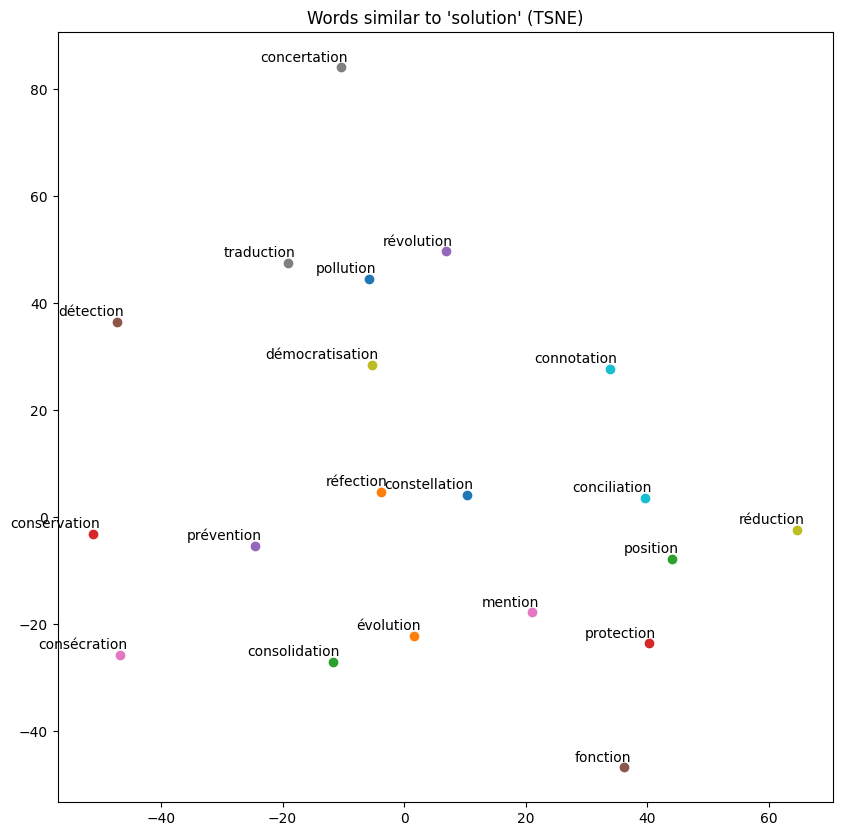

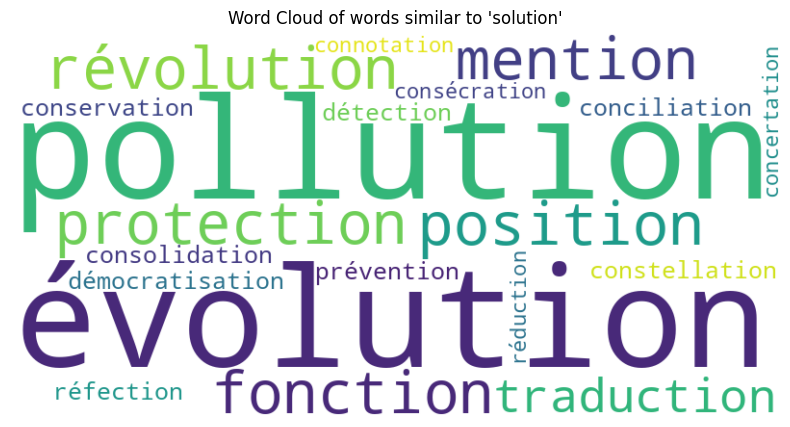

--------------------------------------------------
Visualizations for: jaune

Model: word2vec_cbow_med
[('aux', 0.998078465461731), ('de', 0.998008131980896), ('et', 0.9980031251907349), ('du', 0.9980005025863647), ('entre', 0.9979760646820068), ('la', 0.9979661703109741), ('des', 0.9979568123817444), ('en', 0.9979562759399414), ('au', 0.9979559183120728), ('les', 0.9979486465454102), ('une', 0.9979445934295654), ('un', 0.9979259371757507), ('dans', 0.9979142546653748), ('chez', 0.9978926777839661), ('cas', 0.9978907704353333), ('sont', 0.9978902339935303), ('qui', 0.9978772401809692), ('etude', 0.9978763461112976), ('apres', 0.9978693723678589), ('activite', 0.997868537902832)]


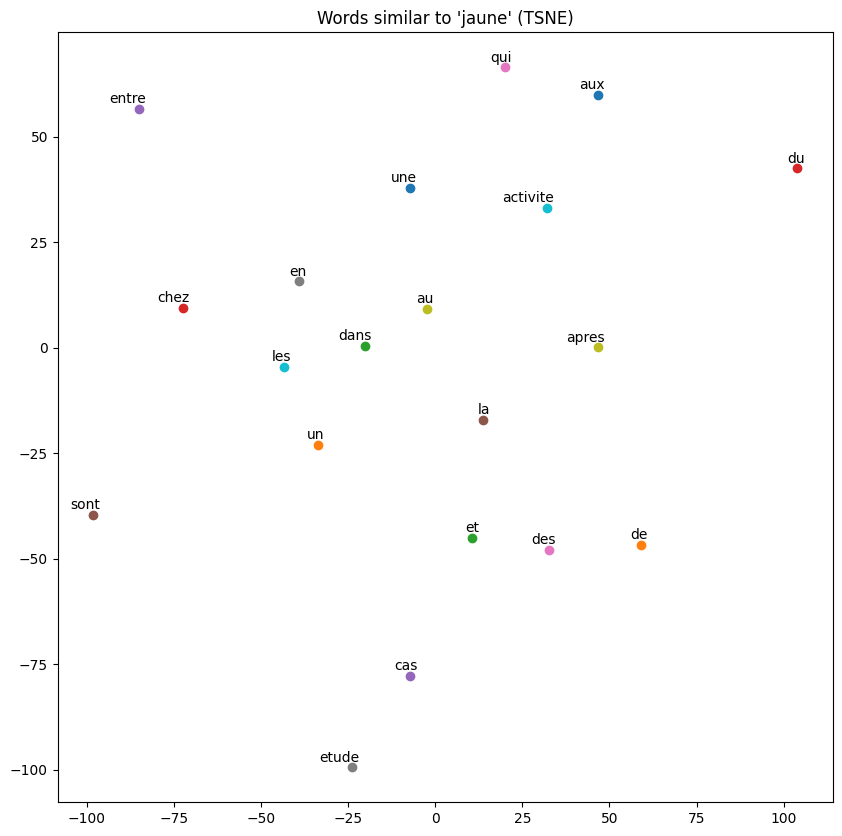

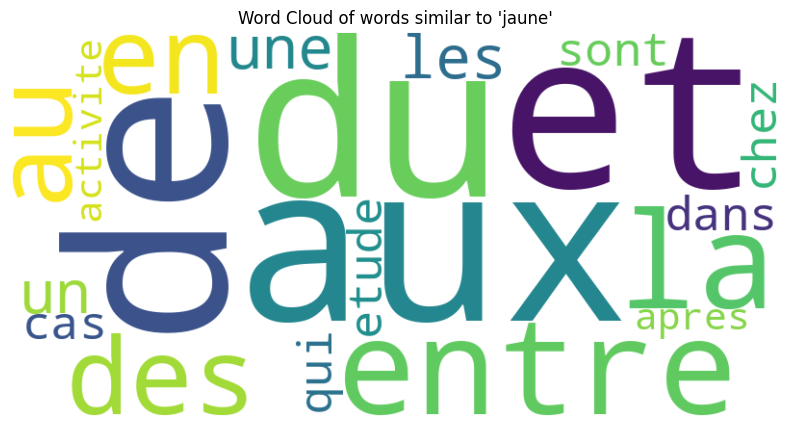

--------------------------------------------------
Model: word2vec_skipgram_med
[('externe', 0.9984732270240784), ('equilibre', 0.9984563589096069), ('exposition', 0.9982603788375854), ('methode', 0.9982441067695618), ('groupe', 0.9982202649116516), ('intra', 0.9982172846794128), ('heure', 0.9980993866920471), ('initiale', 0.9980624914169312), ('temperature', 0.9980523586273193), ('separation', 0.9980356097221375), ('sans', 0.9980232119560242), ('recherche', 0.9980197548866272), ('periode', 0.9979586601257324), ('comprises', 0.9979488849639893), ('environ', 0.9979274272918701), ('continue', 0.9979194402694702), ('journaliere', 0.9979109764099121), ('eventuelle', 0.99787437915802), ('sensation', 0.9978403449058533), ('etaient', 0.9978391528129578)]


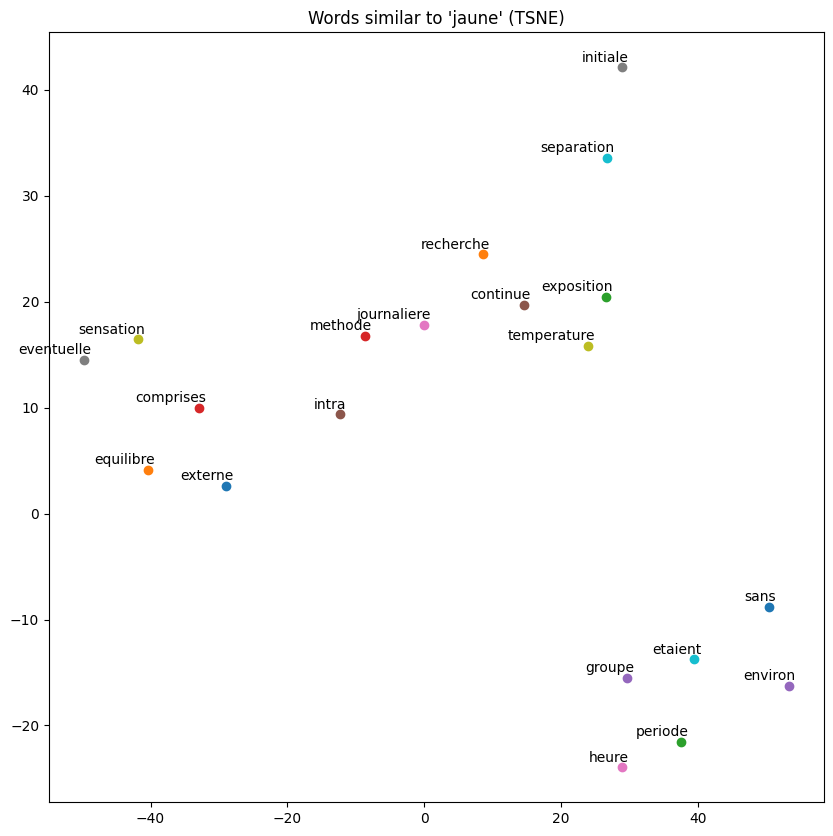

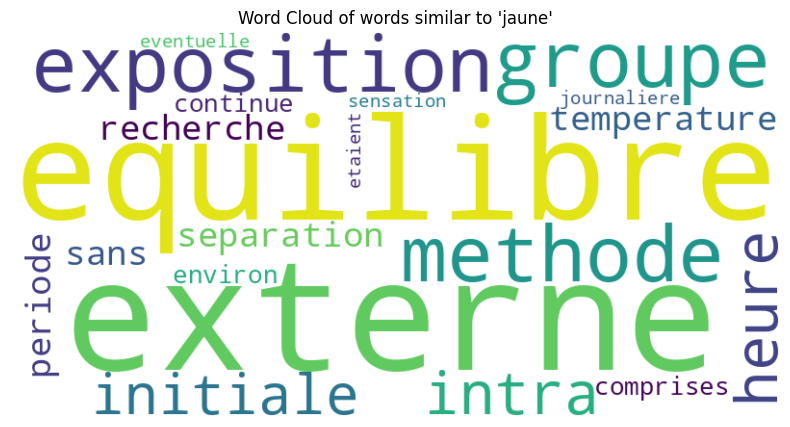

--------------------------------------------------
Model: word2vec_cbow_press
[('maillot', 0.9795022010803223), ('magic', 0.9629234671592712), ('dark', 0.9613946676254272), ('thierry', 0.9594684839248657), ('quai', 0.9584788084030151), ('docteur', 0.9576112031936646), ('constructeur', 0.9562134146690369), ('ouattara', 0.9550999402999878), ('lachhab', 0.9549532532691956), ('ultra', 0.9545619487762451), ('rose', 0.9527257680892944), ('joueur', 0.9520300030708313), ('spadea', 0.95066237449646), ('ferrero', 0.9504953026771545), ('samson', 0.9500453472137451), ('roland', 0.9496439099311829), ('severe', 0.9495610594749451), ('van', 0.9493048787117004), ('celebre', 0.9485520124435425), ('thomson', 0.9484032392501831)]


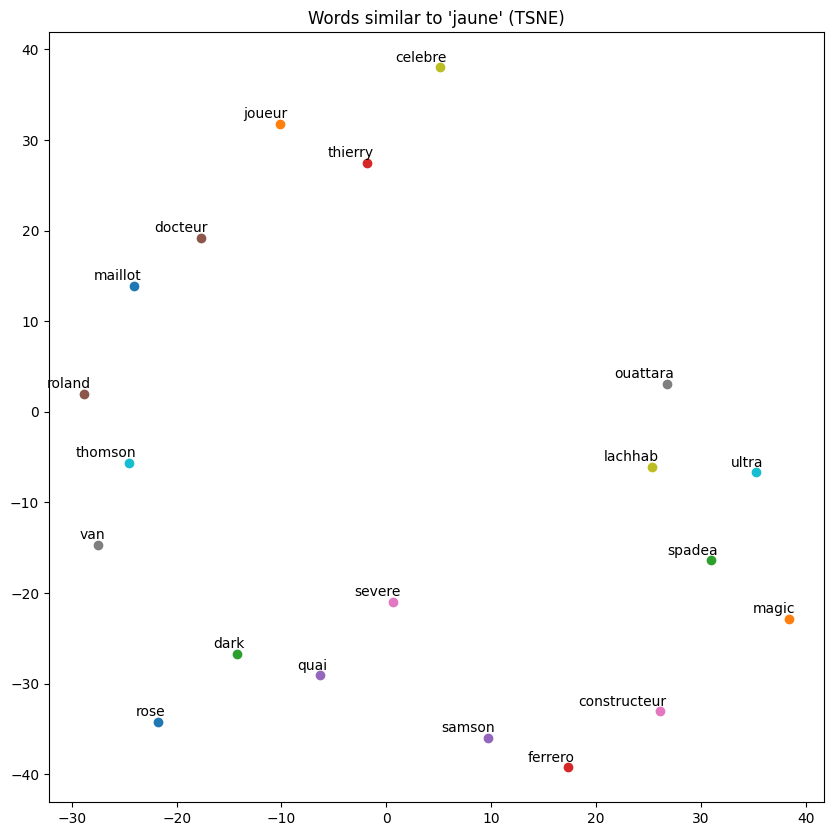

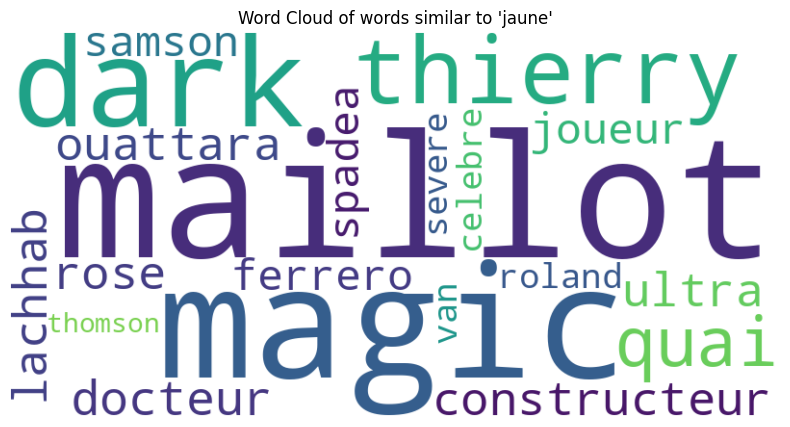

--------------------------------------------------
Model: word2vec_skipgram_press
[('maillot', 0.9512056112289429), ('nadal', 0.9159150719642639), ('rafael', 0.9074519872665405), ('empare', 0.9027851819992065), ('bastad', 0.8999766707420349), ('chelem', 0.8924294710159302), ('metal', 0.8892897963523865), ('abdesslam', 0.8874334692955017), ('mcgee', 0.8871694207191467), ('saut', 0.884570837020874), ('oscar', 0.8834052085876465), ('prologue', 0.8829020261764526), ('revenue', 0.8826246857643127), ('derghal', 0.8822357654571533), ('atp', 0.8818653225898743), ('guerrouj', 0.8814055919647217), ('schumacher', 0.8800078630447388), ('saoudien', 0.8796659708023071), ('azoulay', 0.8792670369148254), ('adjuge', 0.8781998157501221)]


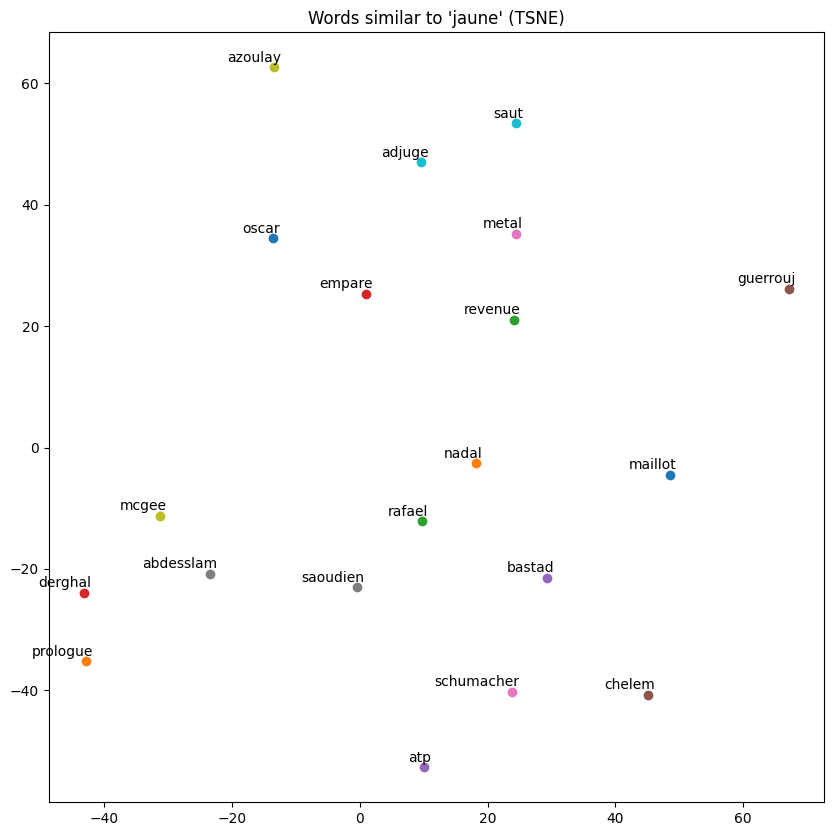

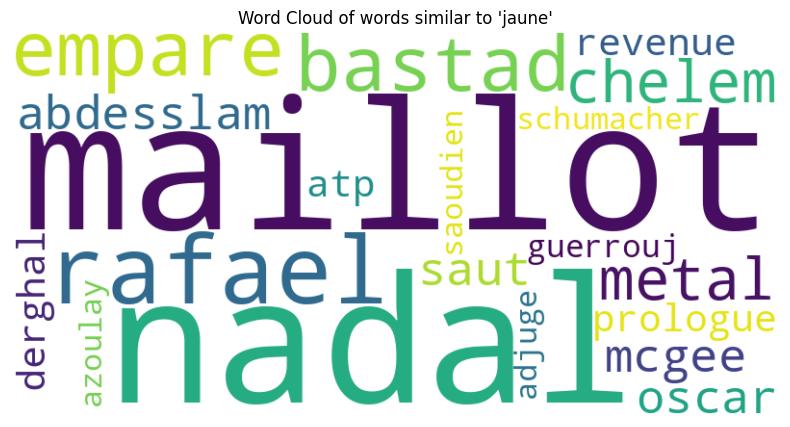

--------------------------------------------------
Model: fasttext_cbow_med
[(0.9999930262565613, 'approximativement'), (0.9999930262565613, 'immunohistologique'), (0.9999929666519165, 'instruments'), (0.999992847442627, 'spécialement'), (0.999992847442627, 'comparativement'), (0.999992847442627, 'symptomatique'), (0.999992847442627, 'graves'), (0.999992847442627, 'complémentaire'), (0.999992847442627, 'approches'), (0.999992847442627, 'démentielles'), (0.9999927282333374, 'validation'), (0.9999927282333374, 'prélèvements'), (0.9999927282333374, 'élaboration'), (0.9999927282333374, 'parasitoses'), (0.9999927282333374, 'infantile'), (0.9999927282333374, 'comparées'), (0.9999927282333374, 'position'), (0.9999927282333374, 'instable'), (0.9999927282333374, 'vaccination'), (0.9999926090240479, 'fécondation')]


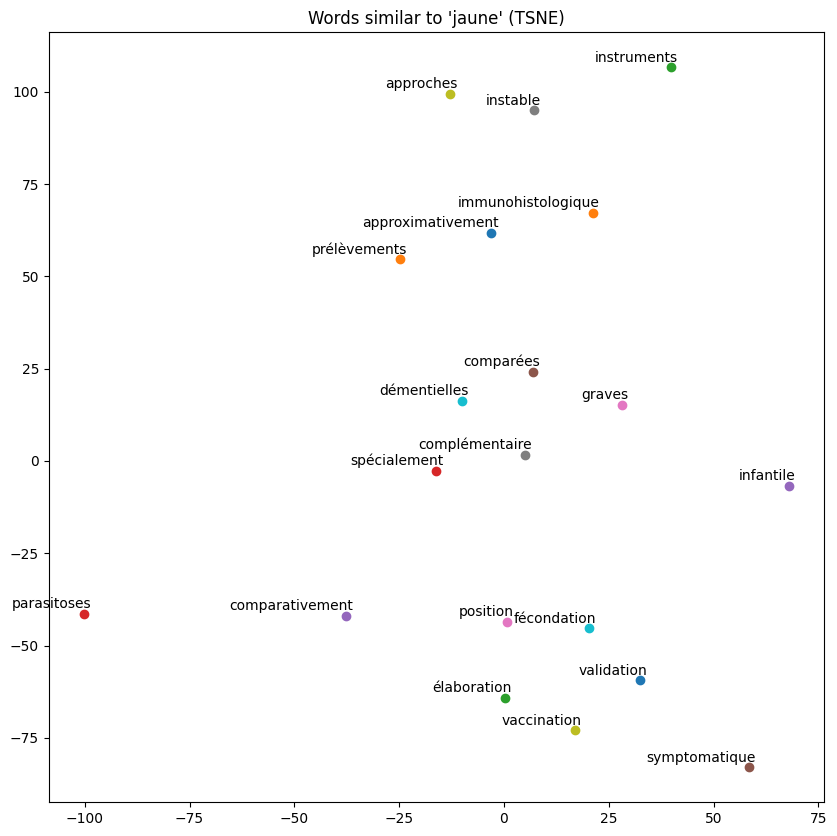

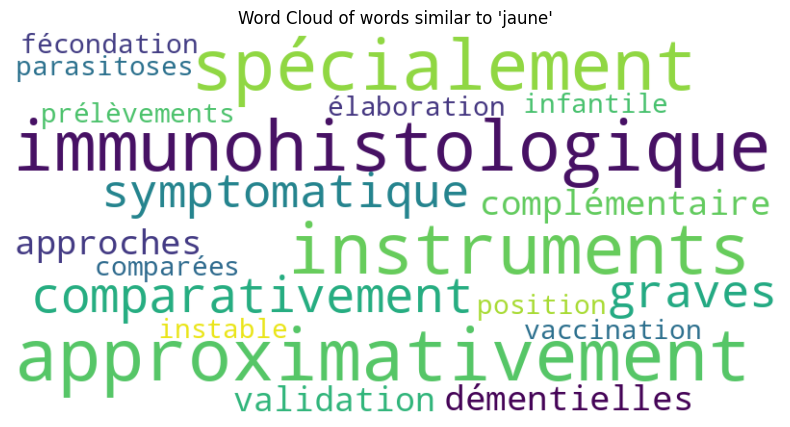

--------------------------------------------------
Model: fasttext_cbow_press
[(0.9986553192138672, 'maurin'), (0.9977987408638, 'rochd'), (0.9972450733184814, 'michel'), (0.9972009062767029, 'romarin'), (0.9969375133514404, 'roch'), (0.996842086315155, 'roll'), (0.996692419052124, 'jeûne'), (0.9962924718856812, 'philippine'), (0.9961671233177185, 'rolf'), (0.9961247444152832, 'josiane'), (0.9960198998451233, 'itp'), (0.9954144954681396, 'michal'), (0.9952493906021118, 'secour'), (0.9951915144920349, 'chami'), (0.995103657245636, 'christ'), (0.9950777292251587, 'christian'), (0.9950456619262695, 'ezekiel'), (0.9950180649757385, 'marshall'), (0.9949498772621155, 'joan'), (0.994899570941925, 'christophe')]


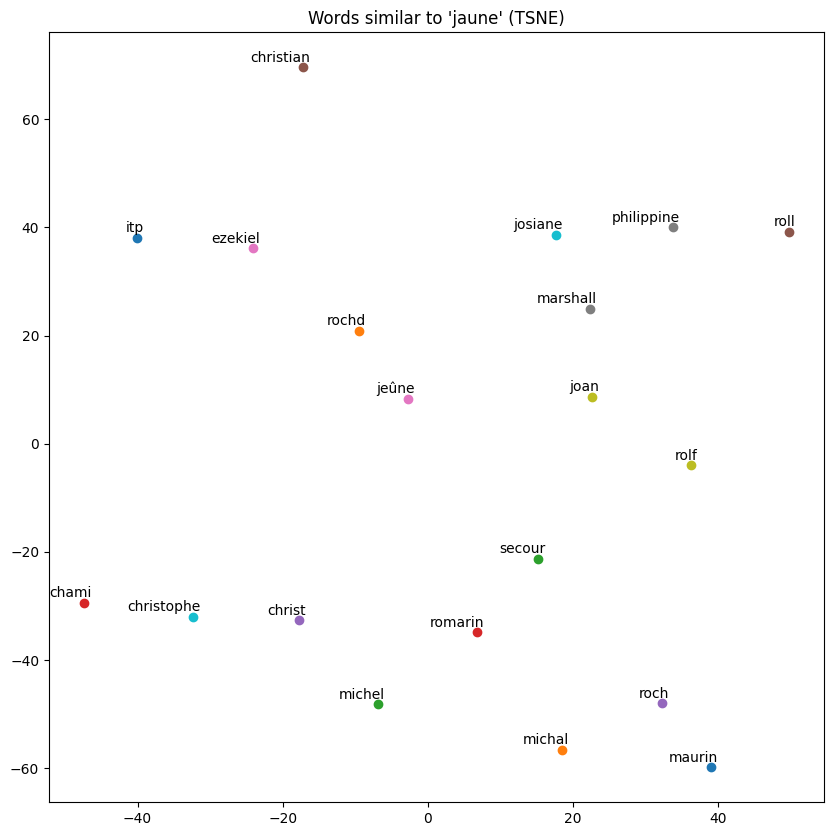

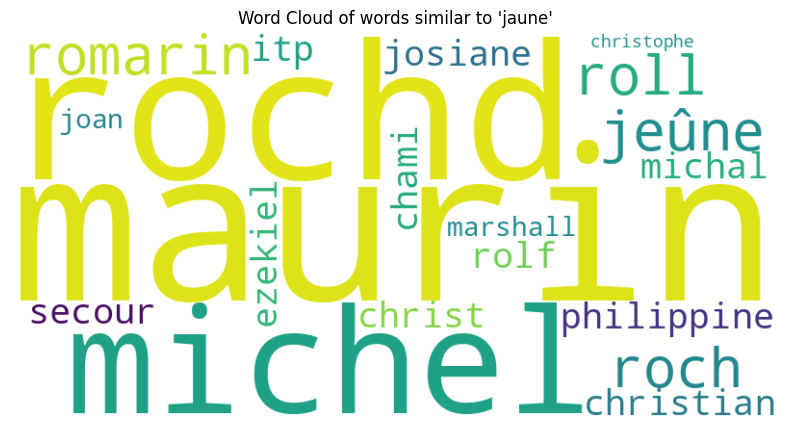

--------------------------------------------------


In [ ]:
for word in candidate_words:
  print(f"Visualizations for: {word}\n")
  for model_name, model in models.items():
      print(f"Model: {model_name}")
      visualize_similarwords(model, word)
      print("-" * 50)